# Problem Statement


## Business Problem Overview
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

 

For many incumbent operators, retaining high profitable customers is the number one business goal.

 

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

 

In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

## Understanding the Business Objective and the Data
The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively. 


The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

## Understanding Customer Behaviour During Churn
Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

The ‘churn’ phase: In this phase, the customer is said to have churned. You define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, you discard all data corresponding to this phase.

 

In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

# Imports & Data Loading

In [87]:
# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.metrics import  roc_auc_score,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier 
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import time

In [88]:
import warnings
warnings.filterwarnings("ignore")

In [89]:
# Read the data
cust = pd.read_csv("data/telecom_churn_data.csv")

In [90]:
cust.shape

(99999, 226)

In [91]:
cust.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [92]:
# Smaller file to manually check on the first 10 records in the dataset
cust.head(10).T.to_csv("sample_10_T.csv")

In [93]:
cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


# Utility Methods

## Check for missing values in a dataframe

In [94]:
# Check for missing values in the dataframe and print them
def print_missing_columns(input_df):
    # Print missing percentage of only columns with missing values
    missing_columns = input_df.columns[input_df.isnull().any()]
    if not missing_columns.empty:
        missing_count = input_df[missing_columns].isnull().sum()
        missing_col_type = pd.Series([type(col) for col in input_df[missing_columns]],index = missing_columns) 
        unique_count = input_df[missing_columns].nunique()

        missing_df = pd.concat({
                        "Missing": missing_count, 
                        "Missing %": missing_count/len(input_df.index)*100,
                        #"Type": missing_col_type,
                        "Unique Count": unique_count
                       } , 
                       axis = 1).sort_values(by = 'Missing', ascending = False)

        display(missing_df)
    else:
        display("NO MISSING VALUES IN THE DATAFRAME")

# Data Preprocessing

## <TODO> Check data types

In [95]:
cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


Date columns are present as objects. Convert to datetime type.

In [96]:
# Change data type of date columns to datetime
date_cols = [col for col in cust.columns if re.match('^date|^last_date', col)]
cust[date_cols] = cust[date_cols].apply(pd.to_datetime,errors='coerce') 

## Check for missing data

In [97]:
print_missing_columns(cust)

,Missing,Missing %,Type,Unique Count
count_rech_2g_6,74846,74.846748,<class 'str'>,31
max_rech_data_6,74846,74.846748,<class 'str'>,48
arpu_3g_6,74846,74.846748,<class 'str'>,7418
av_rech_amt_data_6,74846,74.846748,<class 'str'>,887
count_rech_3g_6,74846,74.846748,<class 'str'>,25
night_pck_user_6,74846,74.846748,<class 'str'>,2
arpu_2g_6,74846,74.846748,<class 'str'>,6990
fb_user_6,74846,74.846748,<class 'str'>,2
total_rech_data_6,74846,74.846748,<class 'str'>,37
date_of_last_rech_data_6,74846,74.846748,<class 'str'>,30


## Handle missing data

### Replace missing with 0
- Missing 'incoming' & 'outgoing' call related columns can be set to 0 assuming there were no calls received/made for that column type
- Recharge related columns can be set to 0 assuming empty cells indicate no recharge was done in that month
- Minutes of Usage (MoU) and average revenue per user (arpu) columns are also handled similarly 

In [98]:
cust.columns

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6',
       ...
       'sachet_3g_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g'],
      dtype='object', length=226)

In [99]:
# Incoming calls column:
# All columns with incoming call information have the string "ic_" in the column name
# Fill the missing values in these columns with 0
incoming_cols = [col for col in cust.columns if 'ic_' in col]
cust[incoming_cols] = cust[incoming_cols].fillna(0)
print(f'Replaced missing values with 0 for {len(incoming_cols)} incoming columns:{incoming_cols}')

# Outgoing calls column:
# All columns with outgoing call information have the string "og_" in the column name
# Fill the missing values in these columns with 0
outcoming_cols = [col for col in cust.columns if 'og_' in col]
cust[outcoming_cols] = cust[outcoming_cols].fillna(0)
print(f'\nReplaced missing values with 0 for {len(outcoming_cols)} outgoing columns:{outcoming_cols}')

Replaced missing values with 0 for 57 incoming columns:['loc_ic_t2o_mou', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_ic_mou_9', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_t2f_mou_9', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'loc_ic_mou_9', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8', 'std_ic_t2t_mou_9', 'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 'std_ic_t2m_mou_8', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8', 'std_ic_t2f_mou_9', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'std_ic_t2o_mou_9', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'std_ic_mou_9', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'total_ic_mou_9', 'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8', 'spl_ic_mou_9', 'isd_ic_mou_6', 'isd_ic_mou_7', 'i

In [100]:
# Recharge related columns
rech_cols = [col for col in cust.columns if re.match('^count_rech_|^max_rech_|^total_rech_|^av_rech_', col)]
cust[rech_cols] = cust[rech_cols].fillna(0)
print(f'Replaced missing values with 0 for {len(rech_cols)} recharge columns :{rech_cols}')

Replaced missing values with 0 for 32 recharge columns :['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', 'total_rech_num_9', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_amt_9', 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'max_rech_amt_9', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_2g_9', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9']


In [101]:
# OFFNET/ONNET MOU related columns
mou_cols = [col for col in cust.columns if re.match('^onnet_mou|^offnet_mou', col)]
cust[mou_cols] = cust[mou_cols].fillna(0)
print(f'Replaced missing values with 0 for {len(mou_cols)} OFFNET/ONNET MOU columns :{mou_cols}')

Replaced missing values with 0 for 8 OFFNET/ONNET MOU columns :['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'onnet_mou_9', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'offnet_mou_9']


In [102]:
# arpu related columns
arpu_cols = [col for col in cust.columns if re.match('^arpu', col)]
cust[arpu_cols] = cust[arpu_cols].fillna(0)
print(f'Replaced missing values with 0 for {len(arpu_cols)} arpu columns :{arpu_cols}')

Replaced missing values with 0 for 12 arpu columns :['arpu_6', 'arpu_7', 'arpu_8', 'arpu_9', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_3g_9', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'arpu_2g_9']


### Handle date columns

- Last recharges made for talktime and data for each month is provided in the input data<br>
- With this information, we will create a new derived column which has the number of days since the last recharge <br>
- Combine the columns for the good phase & action phase (months 6, 7 & 8) and get the latest date when a recharge was made <br>
- At the beginning of 9th month, get the number of days since the last recharge <br>
<br>
Hypothesis - if the customer has done a recharge recently, they are less likely to churn.  <br>

In [103]:
print(f'Shape before handling date columns:{cust.shape}')

Shape before handling date columns:(99999, 226)


In [104]:
date_cols

['last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'last_date_of_month_9',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_9',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'date_of_last_rech_data_9']

In [105]:
cust[['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']].tail()

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8
99994,2014-06-03,2014-07-20,2014-08-26
99995,2014-06-17,2014-07-17,2014-08-24
99996,2014-06-13,2014-07-26,NaT
99997,2014-06-17,2014-07-19,2014-08-20
99998,2014-06-16,NaT,NaT


In [106]:
# Find the last recharge date in the good phase & action phase (gaphase) together (Months 6,7,8)
last_rech_date_cols = [col for col in cust.columns if re.match('^date_of_last_.*[_6|_7|_8]$', col)]
cust['last_rech_date_gaphase'] = cust[last_rech_date_cols].apply(lambda x: x.max(),axis=1)

In [107]:
# Check for missing values
cust['last_rech_date_gaphase'].isnull().sum()

99

In [108]:
# Missing values in this new column implies no recharge has happend in the 3 months.
# Fill missing value with last date of previous month before the start of good phase
last_rech_date_missing = datetime.datetime(2014, 5, 31)
cust['last_rech_date_gaphase']=cust['last_rech_date_gaphase'].fillna(last_rech_date_missing)

In [109]:
# Create column for number of  days since last recharge
last_date_action_phase = datetime.datetime(2014, 8, 31)
cust['last_rech_num_days'] = (last_date_action_phase - cust['last_rech_date_gaphase']).dt.days

In [110]:
cust[['last_rech_date_gaphase','last_rech_num_days']].head()

,last_rech_date_gaphase,last_rech_num_days
0,2014-08-08,23
1,2014-08-28,3
2,2014-08-14,17
3,2014-08-31,0
4,2014-08-09,22


In [111]:
# drop date columns after creating the days columns
print(f'Shape before dropping date columns:{cust.shape}')
cust.drop(date_cols,inplace=True,axis=1)
cust.drop('last_rech_date_gaphase',inplace=True,axis=1)
print(f'Shape after dropping date columns:{cust.shape}')

Shape before dropping date columns:(99999, 228)
Shape after dropping date columns:(99999, 215)


In [112]:
print_missing_columns(cust)

,Missing,Missing %,Type,Unique Count
night_pck_user_6,74846,74.846748,<class 'str'>,2
fb_user_6,74846,74.846748,<class 'str'>,2
night_pck_user_7,74428,74.428744,<class 'str'>,2
fb_user_7,74428,74.428744,<class 'str'>,2
night_pck_user_9,74077,74.077741,<class 'str'>,2
fb_user_9,74077,74.077741,<class 'str'>,2
night_pck_user_8,73660,73.660737,<class 'str'>,2
fb_user_8,73660,73.660737,<class 'str'>,2


The remaining missing values are filled using the IterativeImputer in sklearn

### IterativeImputer

In [113]:
# Use iterative imputer to fill the rest of the missing colums (fb_user_* and night_pck_user_* columns)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
iter_imputer = IterativeImputer()

fb_night_cols = [col for col in cust.columns if re.match('^fb_user_|^night_pck_user_', col)]

cust[fb_night_cols] = iter_imputer.fit_transform(cust[fb_night_cols])

In [114]:
print_missing_columns(cust)

'NO MISSING VALUES IN THE DATAFRAME'

## Check & Treat for outliers

In [119]:
cust.describe(percentiles = [0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,...,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,last_rech_num_days
count,9.999900e+04,99999.0,99999.0,99999.0,99999.0,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,...,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,7.001207e+09,109.0,0.0,0.0,0.0,282.987358,278.536648,279.154731,261.645069,127.183397,...,0.854851,0.845752,0.839821,0.836040,1219.854749,68.170248,66.839062,60.021204,3.299373,7.148231
std,6.956694e+05,0.0,0.0,0.0,0.0,328.439770,338.156291,344.474791,341.998630,292.433718,...,0.209511,0.220306,0.227753,0.230755,954.733842,267.580450,271.201856,253.938223,32.408353,10.683080
min,7.000000e+09,109.0,0.0,0.0,0.0,-2258.709000,-2014.045000,-945.808000,-1899.505000,0.000000,...,-0.071595,-0.134228,-0.131123,-0.275148,180.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1%,7.000025e+09,109.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.014127,189.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5%,7.000122e+09,109.0,0.0,0.0,0.0,1.500000,0.750000,0.000000,0.000000,0.000000,...,0.166901,0.139313,0.077313,0.047201,229.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10%,7.000244e+09,109.0,0.0,0.0,0.0,31.647200,29.355800,18.054200,0.090000,0.000000,...,0.854851,0.845752,0.839821,0.836040,286.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000606e+09,109.0,0.0,0.0,0.0,93.411500,86.980500,84.126000,62.685000,5.430000,...,0.854851,0.845752,0.839821,0.836040,467.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,7.001205e+09,109.0,0.0,0.0,0.0,197.704000,191.640000,192.080000,176.849000,30.980000,...,0.854851,0.845752,0.839821,0.836040,863.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,7.001812e+09,109.0,0.0,0.0,0.0,371.060000,365.344500,369.370500,353.466500,112.610000,...,0.997024,0.996959,0.996960,0.993269,1807.500000,0.000000,0.000000,0.000000,0.000000,7.000000


**NOTE on outliers:** 
- Almost all the columns have outliers in the last one percentile.  
- It requires more domain knowledge to understand on how the outliers should be treated.  
- Some options to treat the outliers:  
    1. Remove rows above the upper cap (could be 99% in this case)
    2. Cap the values in the last percentile to 99%
    3. Don't modify the data if it is expected 
- In this case study, we will check on the arpu columns and remove the outliers in these variables  
 

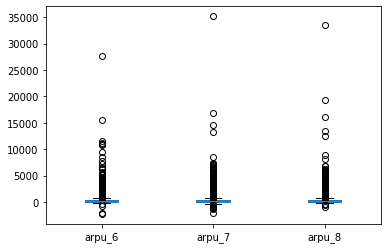

In [120]:
cust[['arpu_6','arpu_7','arpu_8']].plot.box()

In [121]:
# Drop outliers with a cap of 99% on the arpu columns
columns_outliers = ['arpu_6','arpu_7','arpu_8']

cap_arpu_6 = cust['arpu_6'].quantile(.99)
cap_arpu_7 = cust['arpu_7'].quantile(.99)
cap_arpu_8 = cust['arpu_8'].quantile(.99)
cust =  cust[(cust['arpu_6'] <= cap_arpu_6) & (cust['arpu_7'] <= cap_arpu_7) & (cust['arpu_8'] <= cap_arpu_8)] 


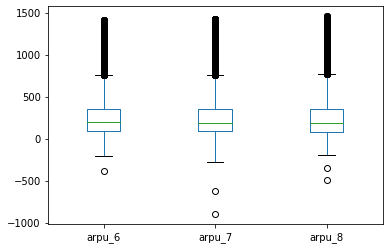

In [122]:
cust[['arpu_6','arpu_7','arpu_8']].plot.box()

In [123]:
cust.shape

(98041, 215)

In [124]:
cust.describe(percentiles = [0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,...,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,last_rech_num_days
count,9.804100e+04,98041.0,98041.0,98041.0,98041.0,98041.000000,98041.000000,98041.000000,98041.000000,98041.000000,...,98041.000000,98041.000000,98041.000000,98041.000000,98041.000000,98041.000000,98041.000000,98041.000000,98041.000000,98041.000000
mean,7.001207e+09,109.0,0.0,0.0,0.0,260.320312,254.611844,255.664261,242.988043,118.270506,...,0.854513,0.845374,0.839404,0.835613,1220.918728,62.048232,60.696221,54.210008,2.923780,7.202079
std,6.958365e+05,0.0,0.0,0.0,0.0,236.731151,236.088674,241.455939,253.622200,256.312305,...,0.208553,0.219347,0.226764,0.229805,955.345362,235.716288,240.844109,223.625920,29.167377,10.711587
min,7.000000e+09,109.0,0.0,0.0,0.0,-383.565000,-897.035000,-491.545000,-1474.195000,0.000000,...,-0.071595,-0.134228,-0.131123,-0.275148,180.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1%,7.000025e+09,109.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.014127,189.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5%,7.000122e+09,109.0,0.0,0.0,0.0,1.350000,0.690000,0.000000,0.000000,0.000000,...,0.166901,0.139313,0.077313,0.047201,229.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10%,7.000244e+09,109.0,0.0,0.0,0.0,31.000000,28.510000,17.749000,0.070000,0.000000,...,0.854851,0.845752,0.839821,0.836040,286.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000606e+09,109.0,0.0,0.0,0.0,91.855000,85.519000,82.788000,61.719000,5.260000,...,0.854851,0.845752,0.839821,0.836040,467.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,7.001204e+09,109.0,0.0,0.0,0.0,193.467000,187.268000,187.879000,173.205000,30.080000,...,0.854851,0.845752,0.839821,0.836040,865.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,7.001812e+09,109.0,0.0,0.0,0.0,357.983000,352.190000,356.587000,342.214000,108.130000,...,0.997024,0.992909,0.992426,0.988699,1811.000000,0.000000,0.000000,0.000000,0.000000,7.000000


## Remove columns with only one unique value. 
Columns with only one unique value will not add much value to the analysis and can be removed

In [126]:
cust = cust[[col for col in cust.columns if cust[col].nunique() > 1]]


## Drop ID column - mobile_number

In [127]:
cust.drop(['mobile_number'],axis=1,inplace=True)

In [128]:
cust.shape

(98041, 202)

# Target Variable Creation

## Create Target variable from 9th Month

Create the target variable based on the below rule:
 
Tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are:

total_ic_mou_9,
total_og_mou_9,
vol_2g_mb_9,
vol_3g_mb_9

In [129]:
# Create churn flag based on the 9th month variables. 
cust['churn'] = (cust['total_ic_mou_9']+cust['total_og_mou_9']+cust['vol_2g_mb_9']+cust['vol_3g_mb_9']) == 0
cust['churn']=cust['churn'].map({True:1,False:0})

In [130]:
cust['churn'].value_counts()

0    88102
1     9939
Name: churn, dtype: int64

## Remove 9th month variables

In [131]:
# drop the columns with the suffix _9, they should not be used while training the model.

print(f'Shape before dropping 9th month columns:{cust.shape}')
month_9_cols = [col for col in cust.columns if re.search('_9$', col)]
cust.drop(month_9_cols,inplace=True,axis=1)
print(f'Shape after dropping 9th month columns:{cust.shape}')

Shape before dropping 9th month columns:(98041, 203)
Shape after dropping 9th month columns:(98041, 154)


Remove the 9th month variables after creating the target variables. Would otherwise lead to data leakage.

# Identify High Value Customers

We need to predict churn only for the high-value customers. <br>
Define high-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

## Find average of M6,M7

In [132]:
cust.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,last_rech_num_days,churn
0,197.385,214.816,213.803,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,1.000000,1.000000,1.000000,968,30.4,0.0,101.20,3.58,23,1
1,34.047,355.074,268.321,24.11,78.68,7.68,15.74,99.84,304.76,0.0,...,0.992156,1.000000,1.000000,1006,0.0,0.0,0.00,0.00,3,0
2,167.690,189.058,210.226,11.54,55.24,37.26,143.33,220.59,208.36,0.0,...,0.989024,0.984316,0.989004,1103,0.0,0.0,4.17,0.00,17,0
3,221.338,251.102,508.054,99.91,54.39,310.98,123.31,109.01,71.68,0.0,...,0.854851,0.845752,0.839821,2491,0.0,0.0,0.00,0.00,0,0
4,261.636,309.876,238.174,50.31,149.44,83.89,76.96,91.88,124.26,0.0,...,0.000000,0.015115,0.016916,1526,0.0,0.0,0.00,0.00,22,0


In [133]:
m6_cols = [col for col in cust.columns if re.search('.*rech.*_6$' , col)]
cust[m6_cols].head()


,total_rech_num_6,total_rech_amt_6,max_rech_amt_6,total_rech_data_6,max_rech_data_6,count_rech_2g_6,count_rech_3g_6,av_rech_amt_data_6
0,4,362,252,1.0,252.0,0.0,1.0,252.0
1,4,74,44,0.0,0.0,0.0,0.0,0.0
2,5,168,86,0.0,0.0,0.0,0.0,0.0
3,10,230,60,0.0,0.0,0.0,0.0,0.0
4,5,196,56,1.0,56.0,1.0,0.0,56.0


In [134]:
# Check if total recharge data column is same as sum of no. of recharges in 2G & 3G
print(cust[cust['total_rech_data_6'] != (cust['count_rech_2g_6']+cust['count_rech_3g_6'])].empty)
print(cust[cust['total_rech_data_7'] != (cust['count_rech_2g_7']+cust['count_rech_3g_7'])].empty)

True
True


<b>Assumption:</b> total_rech_amt_* column is only for the talktime recharge and not for data recharge <br>
This information is not clear in the data dictionary and requires domain knowledge. <br>
We can compute the total rech amount for a month as sum of (talktime recharge + data recharge)

In [135]:
cust['avg_rech_amt_6_7'] = ((cust['total_rech_amt_6'] + cust['total_rech_data_6']*cust['av_rech_amt_data_6']) +
                            (cust['total_rech_amt_7'] + cust['total_rech_data_7']*cust['av_rech_amt_data_7']))/2

In [136]:
cust[['total_rech_amt_6','total_rech_data_6','av_rech_amt_data_6','total_rech_data_7','av_rech_amt_data_7','total_rech_amt_7','avg_rech_amt_6_7']].tail()

,total_rech_amt_6,total_rech_data_6,av_rech_amt_data_6,total_rech_data_7,av_rech_amt_data_7,total_rech_amt_7,avg_rech_amt_6_7
99994,60,0.0,0.0,0.0,0.0,110,85.0
99995,110,0.0,0.0,0.0,0.0,110,110.0
99996,119,2.0,39.0,0.0,0.0,0,98.5
99997,381,3.0,583.0,2.0,358.0,358,1602.0
99998,710,1.0,154.0,0.0,0.0,0,432.0


Manually computing the average recharge amount looks to be correct. <br>
We can now identify the value at the 70th percentile to identify the High Value Customers

## Identify value at 70th percentile

In [137]:
cust[['avg_rech_amt_6_7']].describe(percentiles=[0.1,0.3,0.5,0.7,0.9])

,avg_rech_amt_6_7
count,98041.000000
mean,441.626129
std,675.546034
min,0.000000
10%,60.000000
30%,151.500000
50%,270.000000
70%,458.500000
90%,944.000000
max,29185.500000


In [138]:
avg_70 = cust[['avg_rech_amt_6_7']].quantile(0.7)[0]
print(f'Value at 70th percentile:{avg_70}')

Value at 70th percentile:458.5


## Flag high value customers

In [139]:
cust['is_hvc'] = cust['avg_rech_amt_6_7'].apply(lambda x: int(x>= avg_70))

In [140]:
cust['is_hvc'].value_counts()

0    68627
1    29414
Name: is_hvc, dtype: int64

## Filter data for high value customers

In [141]:
# create a backup before filtering for high value customers
cust_orig = cust.copy()

In [142]:
# Consider only high value customers for the model creation
cust = cust[cust['is_hvc'] == 1]

In [143]:
cust.shape

(29414, 156)

In [144]:
# drop the is_hvc flag column as we have considered only HVCs
cust.drop(['is_hvc'],axis=1,inplace=True)

# Define Variables

In [252]:
# Select columns for EDA
m8_toc_cols = ['loc_og_t2c_mou_8'] # Outgoing calls to call center
aon_cols = ['aon'] # Age on number
mou_cols = [col for col in cust.columns if re.search('^total_.*mou.*' , col)] # Total minutes of usage
arpu_cols = [col for col in cust.columns if re.search('^arpu_.*' , col)] # Average revenue per user

cols_to_analyse = m8_toc_cols+aon_cols+mou_cols+arpu_cols
cols_to_analyse

['loc_og_t2c_mou_8',
 'aon',
 'total_mou_avg',
 'total_mou_gaphase_avg',
 'arpu_avg',
 'arpu_gaphase_avg']

In [146]:
cust[cols_to_analyse].head()

,loc_og_t2c_mou_8,aon,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8
0,0.00,968,0.00,0.00,0.00,0.00,0.00,5.44
8,7.15,315,508.36,431.66,171.56,103.86,28.49,16.54
16,0.00,511,346.81,286.01,233.38,364.86,381.56,294.46
21,0.00,720,860.34,1028.79,1068.54,207.09,131.89,261.04
23,17.71,604,134.38,140.04,239.48,119.58,222.89,298.33


In [147]:
DEPENDENT_VARIABLE = 'churn'
CONTINUOUS_VAR_TO_ANALYSE = cols_to_analyse

# EDA

## Target variable analysis

In [148]:
cust['churn'].isnull().sum()

0

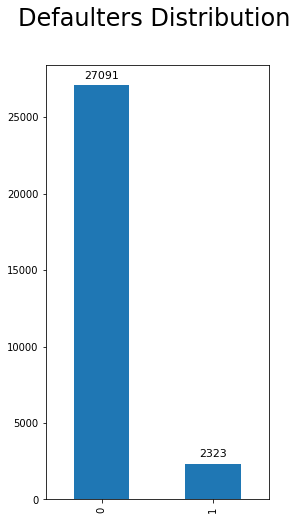

In [149]:
fig = plt.figure(figsize=(4,8))
fig.suptitle('Defaulters Distribution', fontsize=24)
ax = cust[DEPENDENT_VARIABLE].value_counts().plot.bar()
for p in ax.patches: 
    ax.annotate("%0.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11,  xytext=(0, 10), textcoords='offset points')


## Univariate analysis

### Continuous Features - Univariate & Segmented Univariate Analysis

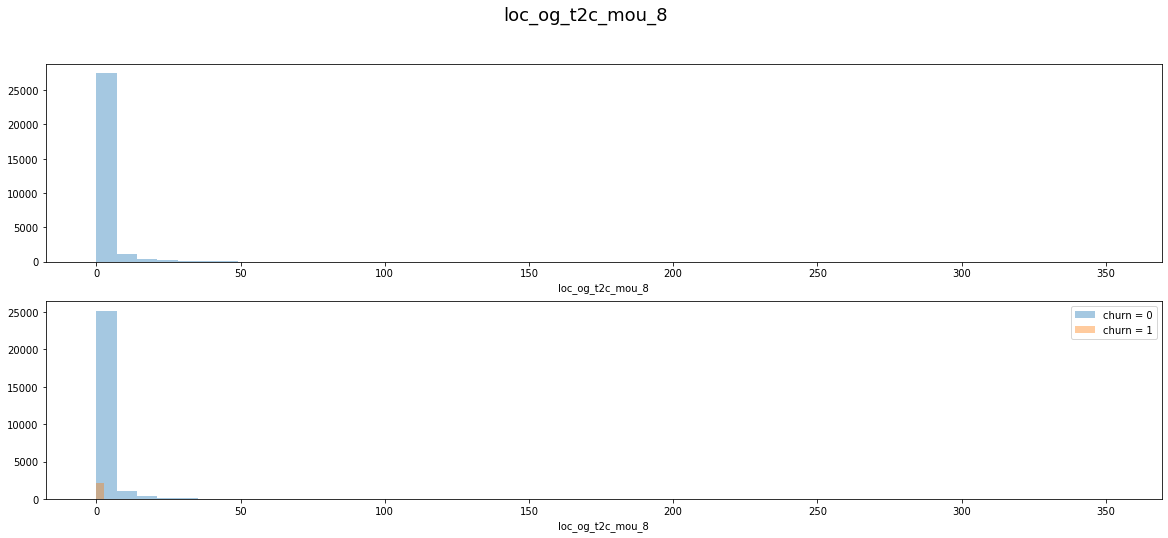

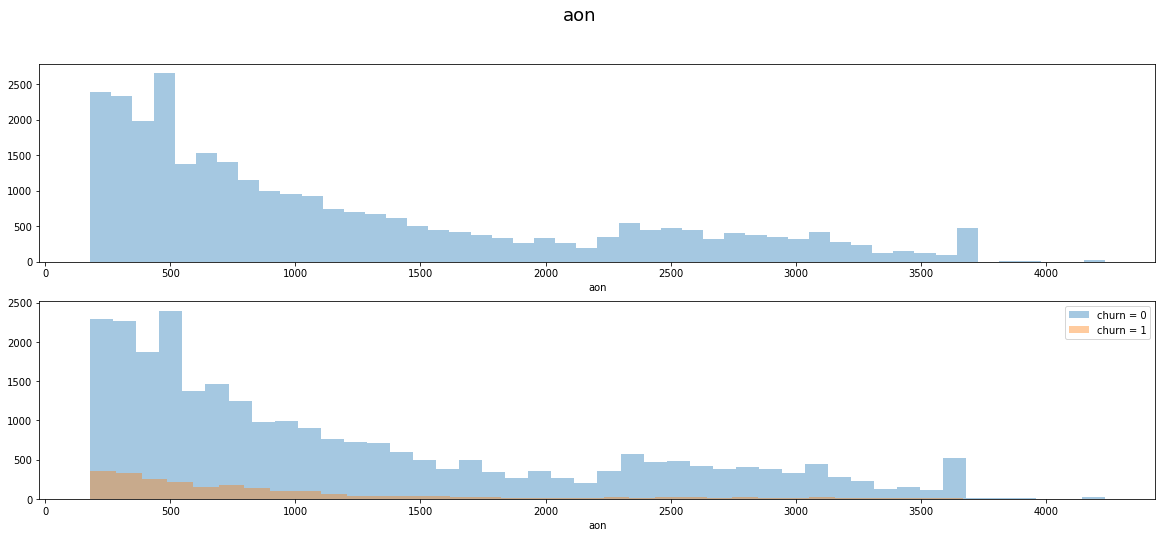

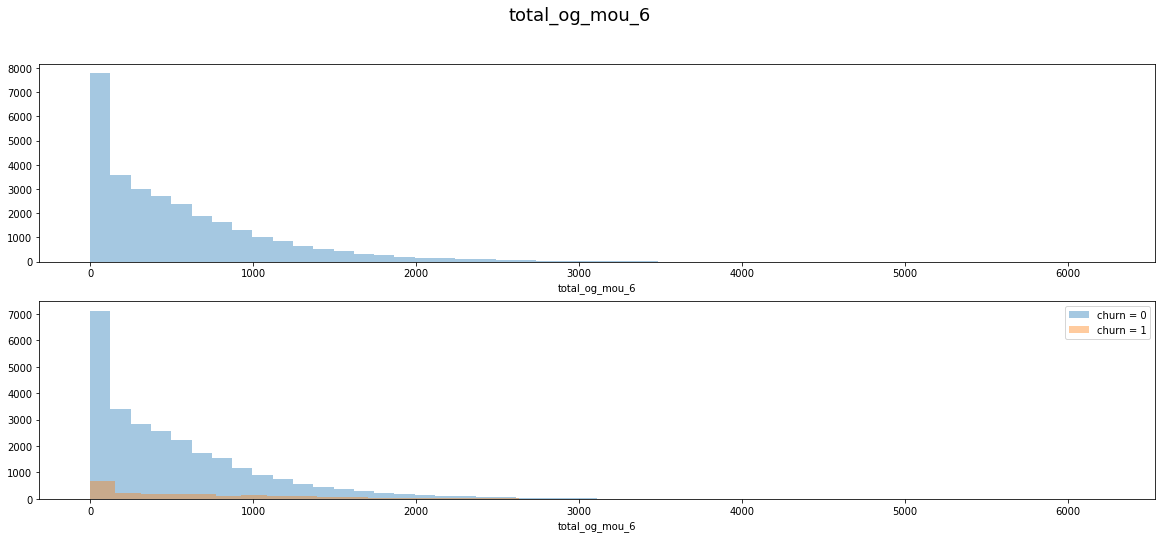

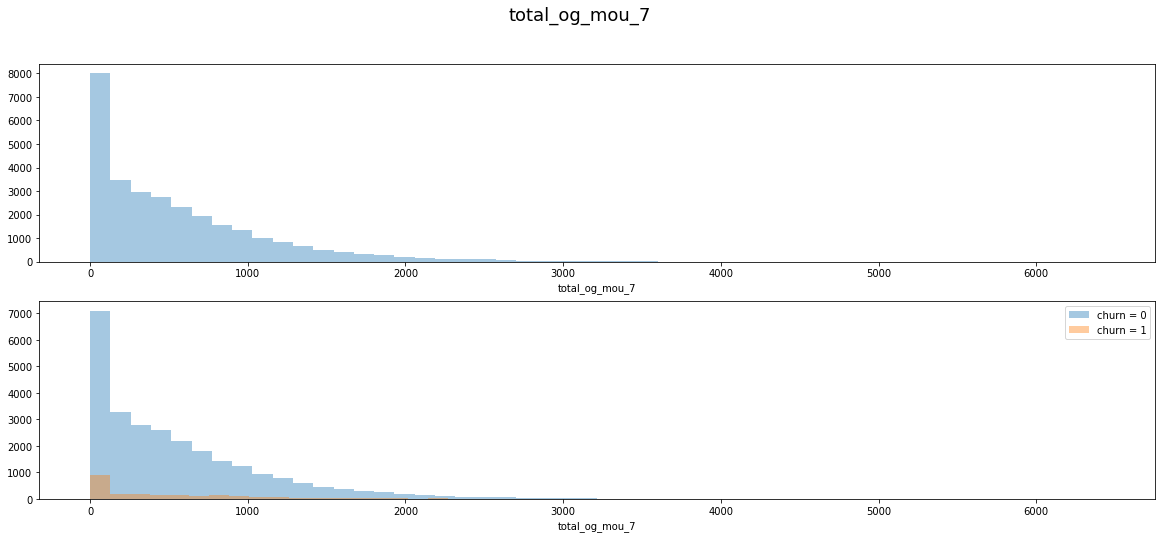

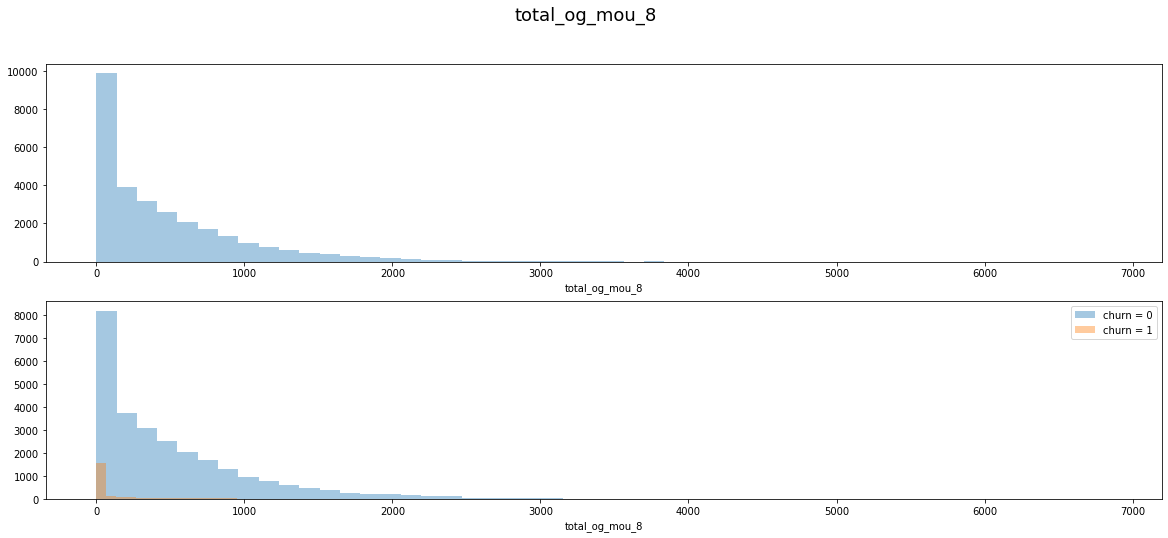

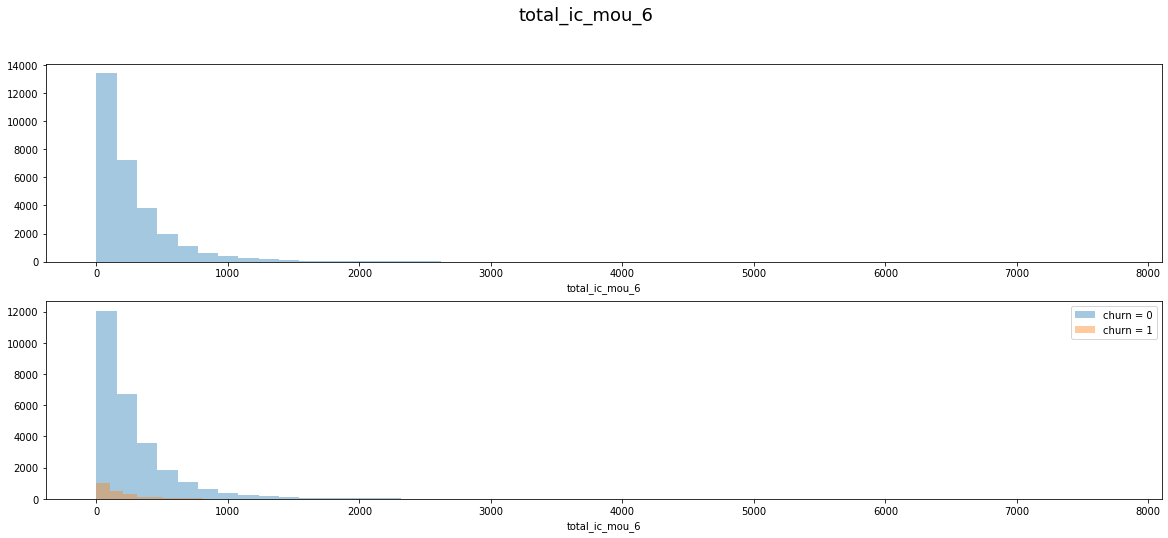

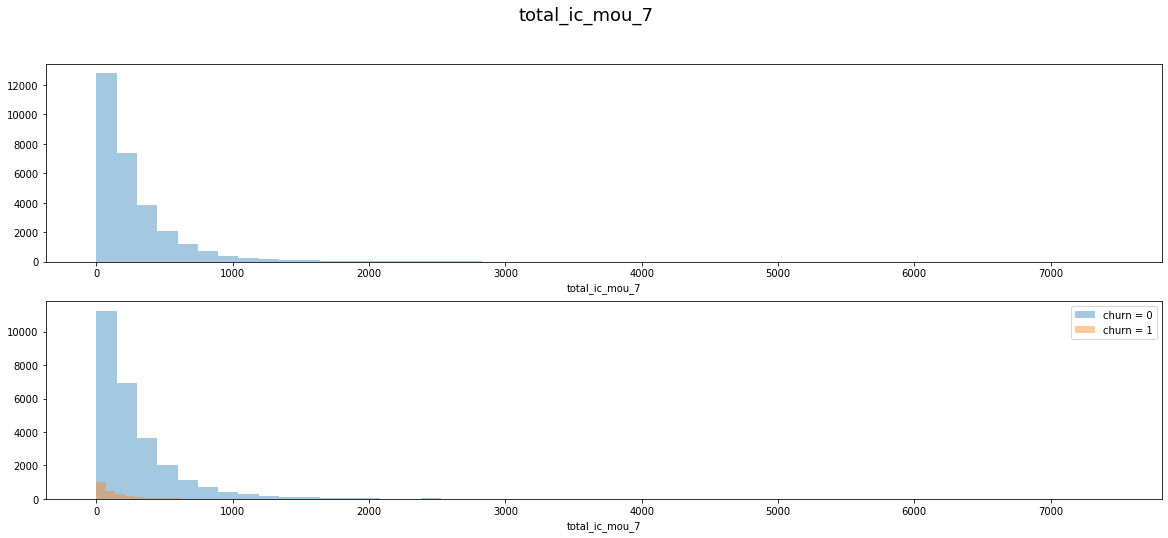

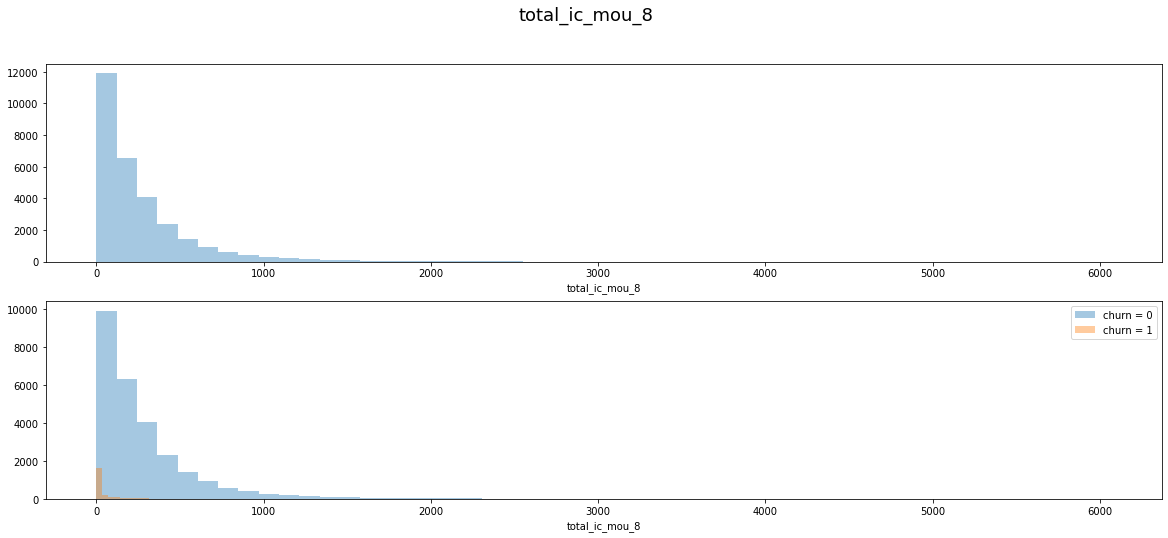

In [150]:

# For each continuous variable, plot
# a. Distribution plot for each continuous variable - Univariate Analysis
# b. Distribution plot against the target variable - Segmented Univariate Analysis
for col in CONTINUOUS_VAR_TO_ANALYSE:
    fig, ax = plt.subplots(2, 1, figsize=(20, 8))
    fig.suptitle(col, fontsize=18)
    sns.distplot(cust[col], kde=False, ax=ax[0])
    for i in sorted(cust[DEPENDENT_VARIABLE].unique()):
        sns.distplot(cust[cust[DEPENDENT_VARIABLE] == i][col], kde=False, ax=ax[1], label=f'{DEPENDENT_VARIABLE} = {i}')
    ax[1].legend()

## Bivariate analysis

### Heat map/correlation matrix

In [151]:
df = cust[CONTINUOUS_VAR_TO_ANALYSE + ['churn']]
corr = df.corr() 

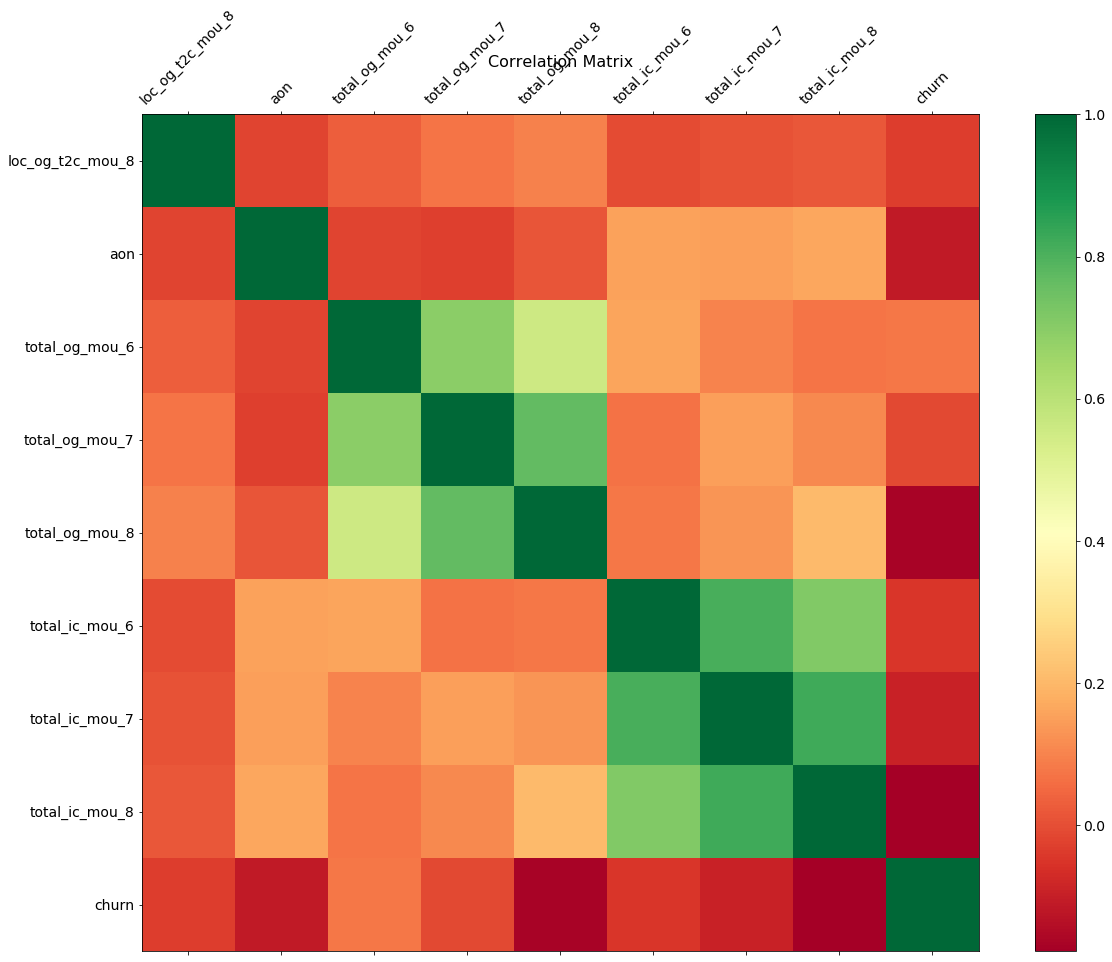

In [152]:
f = plt.figure(figsize=(20, 15))

ax = plt.matshow(corr, fignum=f.number,cmap='RdYlGn')
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#ax.set_ylim([0,2])
plt.title('Correlation Matrix', fontsize=16);

In [153]:

corr.style.background_gradient(cmap='coolwarm').set_precision(1)

,loc_og_t2c_mou_8,aon,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,churn
loc_og_t2c_mou_8,1,-0.02,0.03,0.07,0.1,-0.004,0.008,0.02,-0.03
aon,-0.02,1,-0.02,-0.03,0.01,0.2,0.2,0.2,-0.1
total_og_mou_6,0.03,-0.02,1,0.7,0.6,0.2,0.1,0.07,0.08
total_og_mou_7,0.07,-0.03,0.7,1,0.8,0.07,0.2,0.1,-0.009
total_og_mou_8,0.1,0.01,0.6,0.8,1,0.08,0.1,0.2,-0.2
total_ic_mou_6,-0.004,0.2,0.2,0.07,0.08,1,0.8,0.7,-0.05
total_ic_mou_7,0.008,0.2,0.1,0.2,0.1,0.8,1,0.8,-0.09
total_ic_mou_8,0.02,0.2,0.07,0.1,0.2,0.7,0.8,1,-0.2
churn,-0.03,-0.1,0.08,-0.009,-0.2,-0.05,-0.09,-0.2,1


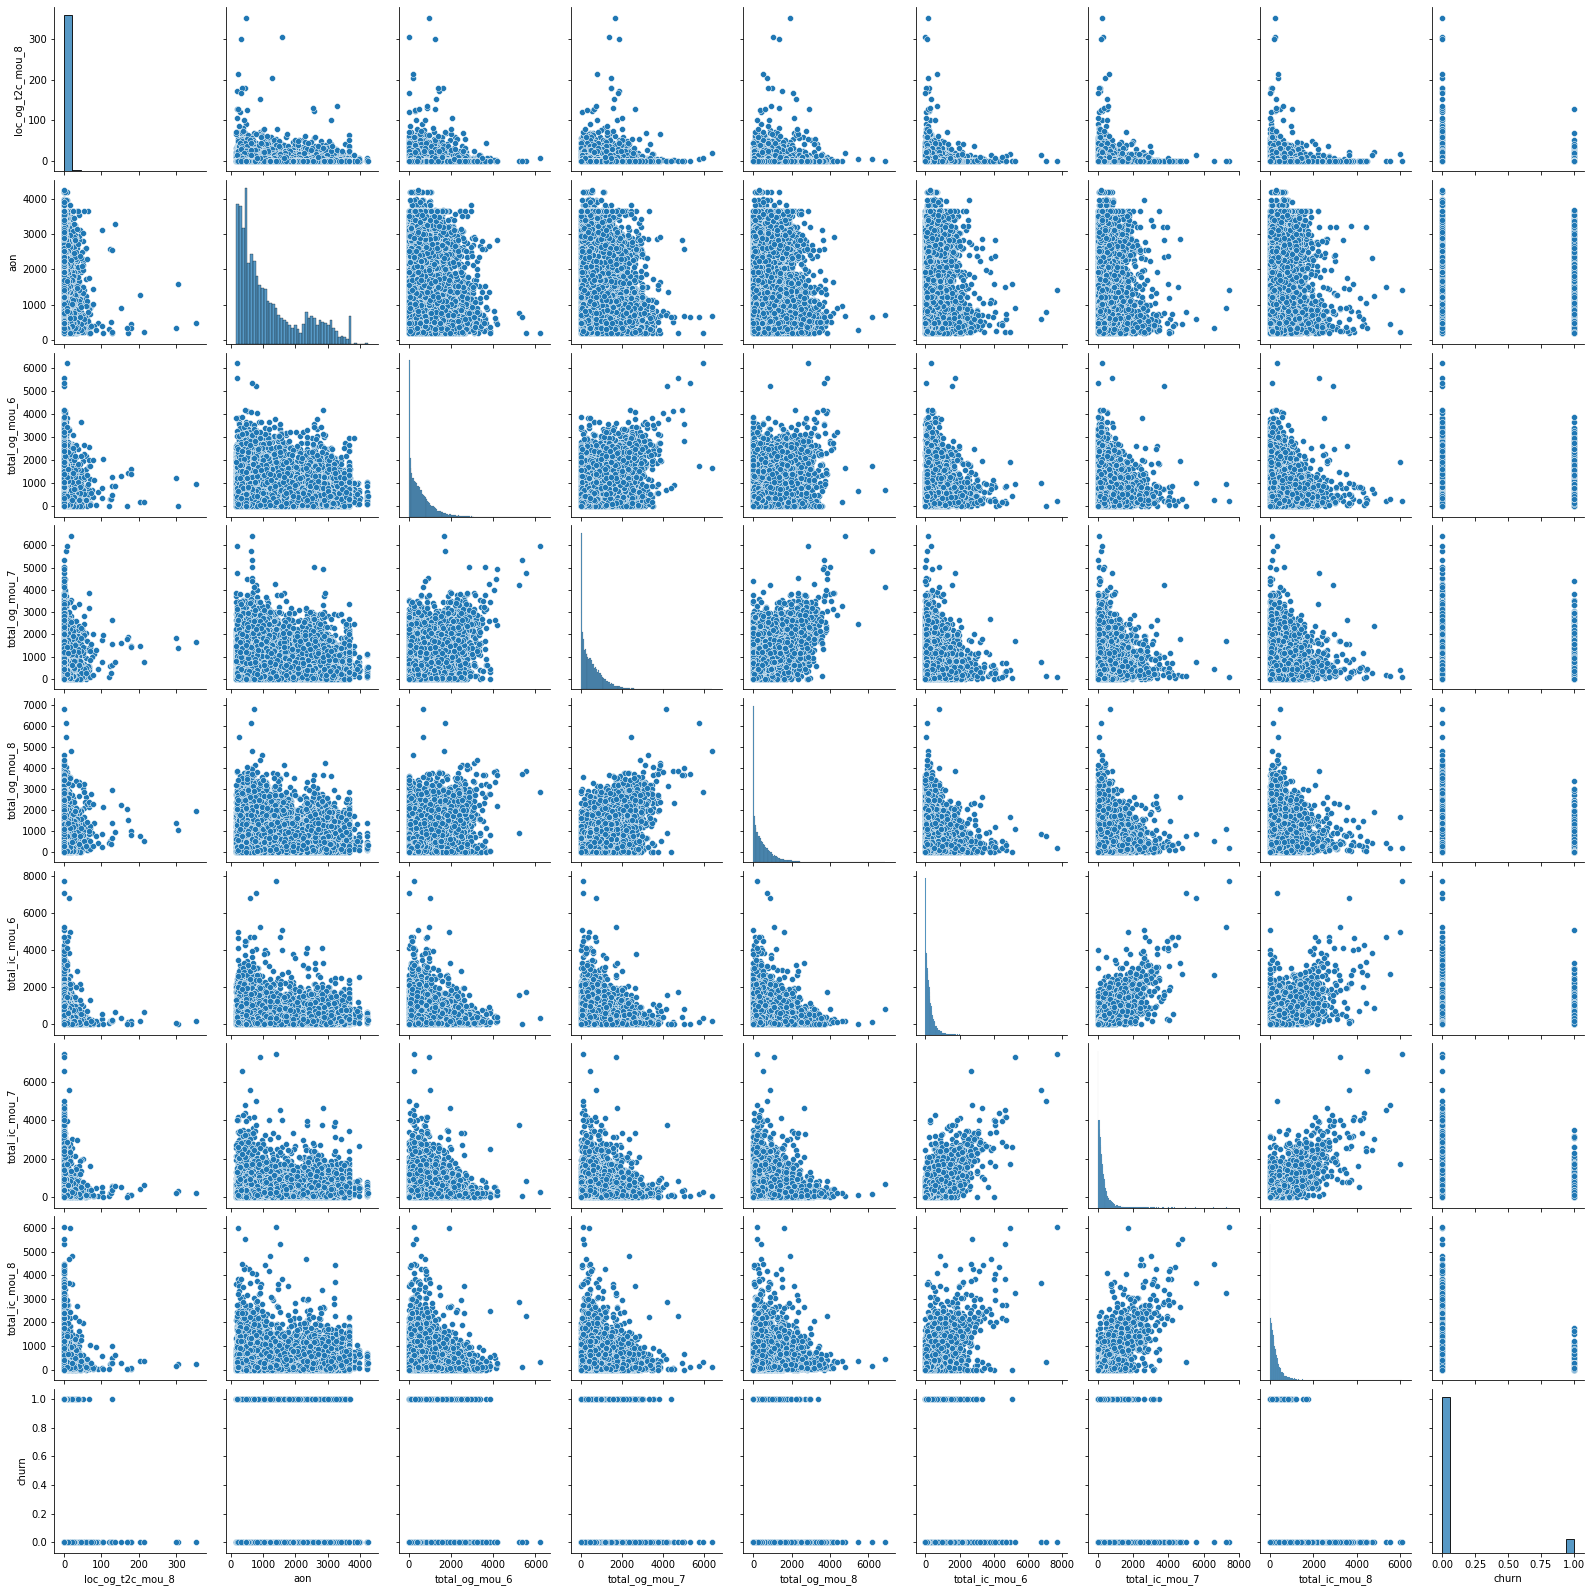

In [154]:
sns.pairplot(df)

<TODO> Insights:
    High correlation between 2 consecutive months (M6 & M7, M7 & M8).<br>
    Good correlation between alternate months (M6 & M8)<br>
--     Churn is negatively correlated to the calls made to the customer care (t2c). More calls to customer care implies more chances of churning.

# Derive new features

- Derive new feature on average usage in good & action phase 
- Derive new feature on usage during action phase vs good phase

In [155]:
# Method to create the derived features for the given column pattern
# 1. Creates two derived features - average of 3 months, good vs action phase
# 2. Drops the features from which the new columns were created to remove multicollinearity
def create_derived_avg_variables(pattern,col_prefix):
   # Create columns for the good phase & action phase
    gphase_cols = [col for col in cust.columns if re.match(f'{pattern}[_6|_7]$', col)]
    aphase_cols = [col for col in cust.columns if re.match(f'{pattern}[_8]$', col)]

    # Get average for 3 months
    cust[f'{col_prefix}_avg'] = round((cust[gphase_cols].sum(axis=1)+cust[aphase_cols].sum(axis=1))/3,2)

    # Get the differece between action phase & average value in good phase
    # Hypothesis: If the values are in negative, it implies that the variable has reduced in the action phase as compared to an average in the good phase - more likely to churn
    cust[f'{col_prefix}_gaphase_avg'] = round(cust[aphase_cols].sum(axis=1) - (cust[gphase_cols].sum(axis=1))/2,2) 
    
    # Verify Values
    print('Sample data for cross-verification:')
    display(cust[gphase_cols + aphase_cols +[f'{col_prefix}_avg',f'{col_prefix}_gaphase_avg']].tail())
    
    # Drop monthly arpu related columns after creating the derived variables
    cust.drop(gphase_cols, axis=1, inplace=True)
    cust.drop(aphase_cols, axis=1, inplace=True)

In [156]:
cust.shape

(29414, 155)

## Derive based on ARPU (Average Revenue Per User)

In [157]:
create_derived_avg_variables('^arpu_.*','arpu')

Sample data for cross-verification:


,arpu_6,arpu_7,arpu_3g_6,arpu_3g_7,arpu_2g_6,arpu_2g_7,arpu_8,arpu_3g_8,arpu_2g_8,arpu_avg,arpu_gaphase_avg
99981,384.316,255.405,212.18,212.18,212.17,212.17,393.474,212.20,212.17,768.76,73.63
99984,328.594,202.966,0.00,0.00,0.02,8.43,118.707,0.00,6.23,221.65,-145.07
99986,644.973,455.228,0.88,0.02,0.00,0.00,564.334,0.05,0.00,555.16,13.83
99988,312.558,512.932,0.00,0.00,0.00,0.00,402.080,5.44,0.00,411.00,-5.23
99997,322.991,303.386,235.68,301.34,235.68,301.34,606.817,602.68,602.68,1170.86,961.97


## Derive based on total MOU (Minutes of Usage)

In [158]:
create_derived_avg_variables('^total.*mou_','total_mou')

Sample data for cross-verification:


,total_og_mou_6,total_og_mou_7,total_ic_mou_6,total_ic_mou_7,total_og_mou_8,total_ic_mou_8,total_mou_avg,total_mou_gaphase_avg
99981,134.81,57.14,478.48,344.78,164.69,420.46,533.45,77.54
99984,464.58,221.64,89.48,123.71,23.98,102.81,342.07,-322.92
99986,1600.79,1183.21,580.73,622.28,1380.01,660.01,2009.01,46.51
99988,375.78,451.48,998.96,374.98,250.79,1233.83,1228.61,384.02
99997,0.00,0.00,0.81,11.09,0.00,2.29,4.73,-3.66


## Derive based on volume of data usage

In [159]:
create_derived_avg_variables('^vol_.*','vol')

Sample data for cross-verification:


,vol_2g_mb_6,vol_2g_mb_7,vol_3g_mb_6,vol_3g_mb_7,vol_2g_mb_8,vol_3g_mb_8,vol_avg,vol_gaphase_avg
99981,54.81,101.02,692.72,596.91,112.07,1012.70,856.74,402.04
99984,1248.50,725.05,0.00,0.00,202.22,0.00,725.26,-784.56
99986,34.28,16.41,736.01,1129.34,6.47,926.78,949.76,-24.77
99988,0.00,0.00,0.00,13.56,0.79,678.74,231.03,672.75
99997,76.51,241.77,1453.63,1382.08,136.47,2683.30,1991.25,1242.78


## Derive based on outgoing calls

In [160]:
# Handle the outgoing calls to customer care separately
create_derived_avg_variables('^loc_og_t2c_mou_','loc_t2c_og')
create_derived_avg_variables('^loc_og_.*','loc_og')

Sample data for cross-verification:


,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_t2c_og_avg,loc_t2c_og_gaphase_avg
99981,3.91,0.00,0.00,1.30,-1.96
99984,17.04,15.38,7.28,13.23,-8.93
99986,15.96,16.71,9.15,13.94,-7.18
99988,0.00,0.00,0.01,0.00,0.01
99997,0.00,0.00,0.00,0.00,0.00


Sample data for cross-verification:


,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_mou_6,loc_og_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_mou_8,loc_og_avg,loc_og_gaphase_avg
99981,72.53,29.04,52.21,20.89,0.00,0.00,124.74,49.94,89.23,55.59,5.76,150.59,216.84,126.49
99984,423.99,181.83,17.96,20.46,0.00,0.00,441.96,202.29,5.71,10.98,0.00,16.69,440.62,-610.86
99986,709.21,496.14,574.93,546.84,16.28,19.48,1300.43,1062.48,718.56,493.48,13.01,1225.06,2391.97,87.21
99988,170.28,146.48,137.83,148.78,0.00,0.00,308.11,295.26,2.46,128.01,0.00,130.48,489.23,-342.42
99997,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## Derive based on incoming calls

In [161]:
create_derived_avg_variables('^loc_ic_.*','loc_ic')

Sample data for cross-verification:


,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_mou_6,loc_ic_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,loc_ic_mou_8,loc_ic_avg,loc_ic_gaphase_avg
99981,285.33,264.44,93.36,61.56,0.30,11.26,378.99,337.28,303.61,58.54,40.41,402.58,745.89,88.88
99984,32.21,45.14,53.49,76.76,0.00,0.00,85.71,121.91,20.94,81.86,0.00,102.81,206.94,-2.00
99986,140.71,104.04,395.58,475.33,29.96,38.69,566.26,618.08,148.21,450.01,37.61,635.84,1213.44,87.35
99988,47.56,3.90,245.31,256.46,14.43,28.39,307.31,288.76,1.50,1122.83,20.31,1144.64,1160.47,1693.22
99997,0.00,0.70,0.81,10.39,0.00,0.00,0.81,11.09,0.00,1.71,0.00,1.71,9.07,-8.48


In [162]:
cust.shape

(29414, 119)

## Derive for the roaming calls

In [163]:
create_derived_avg_variables('^roam_.*_mou_','roam_mou')

Sample data for cross-verification:


,roam_ic_mou_6,roam_ic_mou_7,roam_og_mou_6,roam_og_mou_7,roam_ic_mou_8,roam_og_mou_8,roam_mou_avg,roam_mou_gaphase_avg
99981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Dervice for recharge amount and drop the other rech columns

In [164]:
cust['total_rech_data_amt_6'] = cust['total_rech_data_6']*cust['av_rech_amt_data_6']
cust['total_rech_data_amt_7'] = cust['total_rech_data_7']*cust['av_rech_amt_data_7']
cust['total_rech_data_amt_8'] = cust['total_rech_data_8']*cust['av_rech_amt_data_8']
cust.drop(['total_rech_data_6','av_rech_amt_data_6','total_rech_data_7','av_rech_amt_data_7','total_rech_data_8','av_rech_amt_data_8'],axis=1,inplace=True)

In [165]:
create_derived_avg_variables('^total_rech_.*amt_','total_rech_amt')
create_derived_avg_variables('^count_rech_.*g_','count_rech')
create_derived_avg_variables('^total_rech_num_','total_rech_num')
create_derived_avg_variables('^max_rech_amt_','max_rech_amt')
create_derived_avg_variables('^max_rech_data_','max_rech_data')
create_derived_avg_variables('^last_day_rch_amt_','last_day_rch_amt')


Sample data for cross-verification:


,total_rech_amt_6,total_rech_amt_7,total_rech_data_amt_6,total_rech_data_amt_7,total_rech_amt_8,total_rech_data_amt_8,total_rech_amt_avg,total_rech_amt_gaphase_avg
99981,252,372,252.0,252.0,512,252.0,630.67,200.0
99984,360,239,154.0,484.0,137,585.0,653.00,103.5
99986,567,1130,17.0,14.0,25,25.0,592.67,-814.0
99988,380,554,0.0,154.0,504,154.0,582.00,114.0
99997,381,358,1749.0,716.0,716,2864.0,2261.33,1978.0


Sample data for cross-verification:


,count_rech_2g_6,count_rech_2g_7,count_rech_3g_6,count_rech_3g_7,count_rech_2g_8,count_rech_3g_8,count_rech_avg,count_rech_gaphase_avg
99981,0.0,0.0,1.0,1.0,0.0,1.0,1.00,0.0
99984,1.0,4.0,0.0,0.0,5.0,0.0,3.33,2.5
99986,1.0,1.0,0.0,0.0,1.0,0.0,1.00,0.0
99988,0.0,1.0,0.0,0.0,1.0,0.0,0.67,0.5
99997,1.0,0.0,2.0,2.0,0.0,4.0,3.00,1.5


Sample data for cross-verification:


,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_avg,total_rech_num_gaphase_avg
99981,2,4,3,3.00,0.0
99984,8,10,9,9.00,0.0
99986,6,8,3,5.67,-4.0
99988,12,12,9,11.00,-3.0
99997,3,4,4,3.67,0.5


Sample data for cross-verification:


,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_avg,max_rech_amt_gaphase_avg
99981,252,252,252,252.00,0.0
99984,154,46,30,76.67,-70.0
99986,550,786,25,453.67,-643.0
99988,50,154,154,119.33,52.0
99997,202,179,179,186.67,-11.5


Sample data for cross-verification:


,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_avg,max_rech_data_gaphase_avg
99981,252.0,252.0,252.0,252.00,0.0
99984,154.0,46.0,25.0,75.00,-75.0
99986,17.0,14.0,25.0,18.67,9.5
99988,0.0,154.0,154.0,102.67,77.0
99997,202.0,179.0,179.0,186.67,-11.5


## Derive for std incoming & outgoing

In [245]:
create_derived_avg_variables('^std_og_.*','std_og')
create_derived_avg_variables('^std_ic_.*','std_ic')

Sample data for cross-verification:


,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_mou_6,std_og_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,std_og_mou_8,std_og_avg,std_og_gaphase_avg
99981,6.15,0.00,0.00,0.00,0.0,0.0,6.15,0.00,14.01,0.00,0.0,14.01,13.44,21.87
99984,0.00,0.00,0.03,3.96,0.0,0.0,0.03,3.96,0.00,0.00,0.0,0.00,2.66,-3.99
99986,97.51,53.21,186.88,50.79,0.0,0.0,284.39,104.01,56.84,88.94,0.0,145.79,356.12,-96.82
99988,29.61,27.98,38.04,128.23,0.0,0.0,67.66,156.21,0.00,120.29,0.0,120.29,229.44,16.72
99997,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00


Sample data for cross-verification:


,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_mou_6,std_ic_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,std_ic_avg,std_ic_gaphase_avg
99981,57.60,0.91,0.00,0.00,41.59,6.51,99.19,7.43,17.36,0.00,0.00,17.36,82.65,-71.90
99984,0.00,0.00,2.33,0.75,0.99,1.04,3.33,1.79,0.00,0.00,0.00,0.00,3.41,-5.12
99986,2.31,0.00,12.14,1.03,0.00,2.73,14.46,3.76,0.00,23.71,0.45,24.16,28.25,30.10
99988,10.08,13.21,680.34,72.99,1.01,0.00,691.44,86.21,2.03,86.11,0.71,88.86,577.66,-599.93
99997,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.58,0.00,0.58,0.39,1.16


In [248]:
[col for col in cust.columns if re.search(f'last_day_rch_amt', col)]

['last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8']

In [166]:
# TO ADD

In [167]:
[col for col in cust.columns if re.search(f'rech', col)]

['last_rech_num_days',
 'avg_rech_amt_6_7',
 'total_rech_amt_avg',
 'total_rech_amt_gaphase_avg',
 'count_rech_avg',
 'count_rech_gaphase_avg',
 'total_rech_num_avg',
 'total_rech_num_gaphase_avg',
 'max_rech_amt_avg',
 'max_rech_amt_gaphase_avg',
 'max_rech_data_avg',
 'max_rech_data_gaphase_avg']

In [168]:
cust.shape

(29414, 101)

In [169]:
cust.describe(percentiles = [0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,...,total_rech_amt_avg,total_rech_amt_gaphase_avg,count_rech_avg,count_rech_gaphase_avg,total_rech_num_avg,total_rech_num_gaphase_avg,max_rech_amt_avg,max_rech_amt_gaphase_avg,max_rech_data_avg,max_rech_data_gaphase_avg
count,29414.000000,29414.000000,29414.000000,29414.000000,29414.000000,29414.000000,29414.000000,29414.000000,29414.000000,29414.000000,...,29414.000000,29414.000000,29414.000000,29414.000000,29414.000000,29414.000000,29414.000000,29414.000000,29414.000000,29414.000000
mean,236.100687,240.010311,207.843448,330.006015,331.750852,292.256447,149.236827,155.406228,130.958684,156.590895,...,985.117648,-100.745897,1.679255,-0.135293,10.728912,-1.759706,154.340132,-10.369637,72.435295,-6.339719
std,392.280177,405.171153,376.709715,383.768040,391.877998,366.641757,341.699578,354.134809,328.937597,330.244914,...,991.838222,1122.695216,2.563849,2.152456,7.667293,6.235070,115.322797,116.887140,91.220723,73.611499
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,305.670000,-22200.000000,0.000000,-30.500000,0.330000,-101.500000,0.000000,-1675.000000,0.000000,-951.000000
1%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,333.330000,-2773.635000,0.000000,-7.000000,2.000000,-21.500000,22.042900,-475.935000,0.000000,-252.000000
5%,0.000000,0.000000,0.000000,0.186500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,400.670000,-1224.025000,0.000000,-3.000000,3.330000,-11.000000,33.330000,-154.000000,0.000000,-137.000000
10%,0.580000,0.466000,0.000000,10.640000,9.690000,2.016000,0.000000,0.000000,0.000000,0.000000,...,450.670000,-833.500000,0.000000,-2.000000,4.000000,-7.500000,48.670000,-103.000000,0.000000,-78.500000
25%,16.040000,14.910000,9.640000,66.830000,65.210000,43.115000,0.000000,0.000000,0.000000,0.000000,...,550.670000,-466.000000,0.000000,-0.500000,5.670000,-4.000000,90.000000,-32.000000,0.000000,-6.000000
50%,79.745000,77.000000,60.735000,207.735000,203.385000,169.090000,2.150000,2.010000,0.360000,14.770000,...,737.330000,-125.750000,1.000000,0.000000,8.670000,-1.500000,128.000000,0.000000,25.000000,0.000000
75%,270.422500,267.685000,221.090000,448.852500,453.462500,402.170000,102.347500,106.240000,70.705000,140.670000,...,1071.000000,152.000000,2.000000,0.000000,13.000000,1.000000,183.670000,24.000000,134.670000,0.000000


# Split data to independent & dependent variables

In [170]:
X = cust.drop([DEPENDENT_VARIABLE],axis=1)
y = cust[DEPENDENT_VARIABLE]

# Handle class imbalance

In [171]:
cust['churn'].value_counts()

0    27091
1     2323
Name: churn, dtype: int64

<font color='green'>
    <b>Observations on class imbalance:</b><br>
- In the given dataset, churn vs non-churn is at 10%-90%. <br>
- This is a case of class imbalance where one class outnumbers the other. <br>
- We can apply some of the class imbalance techniques to address this issue and observe how the models behave <br>
- In this case study we shall use the oversampling & SMOTE techniques to address the class imbalance issue
</font>

## Oversampling

In [172]:
# import library
from imblearn.over_sampling import RandomOverSampler

over_sampler = RandomOverSampler(random_state=42)

# fit predictor and target variablex_ros, 
X_oversampled, y_oversampled = over_sampler.fit_resample(X,y)


print(f'''Shape of X before oversampling: {X.shape}
Shape of X after oversampling: {X_oversampled.shape}''')

print('\nBalance of positive and negative classes (%):')
y_oversampled.value_counts(normalize=True) * 100



Shape of X before oversampling: (29414, 100)
Shape of X after oversampling: (54182, 100)

Balance of positive and negative classes (%):


1    50.0
0    50.0
Name: churn, dtype: float64

## SMOTE

In [173]:
from imblearn.over_sampling import SMOTE 

smote = SMOTE(random_state=42)

X_smote, y_smote = smote.fit_resample(X, y)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_smote.shape}''')

print('\nBalance of positive and negative classes (%):')
y_smote.value_counts(normalize=True) * 100

Shape of X before SMOTE: (29414, 100)
Shape of X after SMOTE: (54182, 100)

Balance of positive and negative classes (%):


1    50.0
0    50.0
Name: churn, dtype: float64

# Train-test split

## Train-test split on original data (without oversampling or SMOTE)

In [174]:
# 70% of data used as train data and the remaining 30% as test data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state=100)

## Train-test split on oversampled data 


In [175]:
# 70% of data used as train data and the remaining 30% as test data
X_oversampled_train, X_oversampled_test, y_oversampled_train, y_oversampled_test = train_test_split(X_oversampled,y_oversampled,test_size = 0.3, random_state=100)

## Train-test split on SMOTE data 


In [176]:
# 70% of data used as train data and the remaining 30% as test data
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote,y_smote,test_size = 0.3, random_state=100)

# Feature Scaling

In [177]:
cols_to_scale = X_train.columns

In [178]:
# Scale the original dataset
scaler = MinMaxScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale]  = scaler.transform(X_test[cols_to_scale] )

In [179]:
# Scale the oversampled dataset
scaler_os = MinMaxScaler()
X_oversampled_train[cols_to_scale] = scaler_os.fit_transform(X_oversampled_train[cols_to_scale])
X_oversampled_test[cols_to_scale] = scaler_os.transform(X_oversampled_test[cols_to_scale])

In [180]:
# Scale the SMOTE dataset
scaler_smote = MinMaxScaler()
X_smote_train[cols_to_scale] = scaler_smote.fit_transform(X_smote_train[cols_to_scale])
X_smote_test[cols_to_scale] = scaler_smote.transform(X_smote_test[cols_to_scale])

In [181]:
X_train.describe()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,...,total_rech_amt_avg,total_rech_amt_gaphase_avg,count_rech_avg,count_rech_gaphase_avg,total_rech_num_avg,total_rech_num_gaphase_avg,max_rech_amt_avg,max_rech_amt_gaphase_avg,max_rech_data_avg,max_rech_data_gaphase_avg
count,20589.000000,20589.000000,20589.000000,20589.000000,20589.000000,20589.000000,20589.000000,20589.000000,20589.000000,20589.000000,...,20589.000000,20589.000000,20589.000000,20589.000000,20589.000000,20589.000000,20589.000000,20589.000000,20589.000000,20589.000000
mean,0.038290,0.037710,0.034777,0.092557,0.089612,0.082425,0.042516,0.028629,0.022303,0.044740,...,0.020103,0.352181,0.033259,0.467106,0.085630,0.637174,0.044431,0.296101,0.046604,0.588621
std,0.063238,0.063521,0.062995,0.106773,0.105576,0.103226,0.096875,0.065123,0.056212,0.093646,...,0.029790,0.023110,0.051085,0.033032,0.063438,0.039819,0.034860,0.021000,0.059290,0.045134
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.002629,0.002363,0.001658,0.018689,0.017632,0.012337,0.000000,0.000000,0.000000,0.000000,...,0.007274,0.344642,0.000000,0.461538,0.043889,0.623003,0.025057,0.292319,0.000000,0.589664
50%,0.013125,0.012176,0.010276,0.058481,0.054552,0.047705,0.000617,0.000370,0.000070,0.004172,...,0.012791,0.351693,0.019869,0.469231,0.068546,0.638978,0.036483,0.297831,0.016077,0.592154
75%,0.043813,0.041861,0.036892,0.126625,0.122752,0.113275,0.029812,0.019710,0.012221,0.040529,...,0.022581,0.357485,0.039738,0.469231,0.106846,0.654952,0.053322,0.302098,0.086605,0.592154
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# SET CONFIGURATIONS

## Set models to be run and compared

In [182]:
# All supported models that can be run
ALL_SUPPORTED_MODELS = ['LOGISTRIC_REGRESSION','DECISION_TREE','RANDOM_FOREST','GAUSSIAN_NAIVE_BAYES','GRADIENT_BOOST','XGB_CLASSIFIER','SVM_CLASSIFIER','KNN_CLASSIFIER','ADABOOST_CLASSIFIER','MLP_CLASSIFIER']

# Select models that needs to be run (Set to ALL_SUPPORTED_MODELS if all the models has to be run - RunTime could be high)
MODELS_TO_RUN =     ['LOGISTRIC_REGRESSION','DECISION_TREE','RANDOM_FOREST','GAUSSIAN_NAIVE_BAYES','GRADIENT_BOOST','XGB_CLASSIFIER','ADABOOST_CLASSIFIER']

## Set the evaluation metric

In [183]:
GRID_SEARCH_SCORING  = 'f1'# Metric used to identify the best model during hyperparameter tuning
EVALUATION_METRIC = 'F1 Score' #'Accuracy','AUROC','Sensitivity','Specificity','Precision'
SORT_ASCENDING = False

## Labels in the dataset

In [184]:
labels = list(set(y_test))

## Grid Search for Random Forest - Hyperparameter Tuning

In [185]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [1, 2, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'max_features': [2,3,4],
    'n_estimators': [10, 30, 50, 100, 200]
}

param_comb = 3

# # Instantiate the grid search model - takes around 1hr 22m for PCA RF HPT
# grid_search_rf = GridSearchCV(estimator=classifier_rf, param_grid=params, 
#                           cv=4, n_jobs=-1, verbose=1, scoring = GRID_SEARCH_SCORING)

random_search_rf = RandomizedSearchCV(estimator=classifier_rf, param_distributions=params, n_iter=param_comb, scoring=GRID_SEARCH_SCORING, n_jobs=-1, cv=4, verbose=1, random_state=42)


## Random Search for XGBoost - Hyperparameter Tuning


In [186]:
classifier_xgb = XGBClassifier(n_jobs = -1,objective = 'binary:logistic')

# A parameter grid for XGBoost
params = {
        'n_estimators' : [100, 200, 500, 750], # no of trees 
        'learning_rate' : [0.01, 0.02, 0.05, 0.1, 0.25],  # eta
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0.1, 0.5, 1, 1.5, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 10, 12]
        }

param_comb = 3 # to reduce run-time - testing (did not complete after 3 hours for 800)

random_search_xgb = RandomizedSearchCV(classifier_xgb, param_distributions=params, n_iter=param_comb, scoring=GRID_SEARCH_SCORING, n_jobs=-1, cv=5, verbose=3, random_state=42)


# Helper Functions - Model Building

## Fit & Predict

In [187]:
def model_fit_predict(model,X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return get_performance_measures(Y_test = y_test, Y_predict = y_pred, labels = labels)

## Print elapsed time in min & secc

In [188]:
def print_elapsed_time(end_time,start_time):
    total_time = end_time - start_time
    print(f'Elapsed time: {total_time//60} min {round(total_time - total_time//60,3)} sec')
    
    

## Run models based on MODELS_TO_RUN list

In [189]:
def run_all_models(X_train, X_test, y_train, y_test,model_type, model_result):
    
    start_time = time.time()
    
    # Logistic Regression
    if 'LOGISTRIC_REGRESSION' in MODELS_TO_RUN:
        print(f'\nRunning Model: Logistic Regression')
        model_start_time = time.time()
        model_result[f'{model_type}-LR'] = model_fit_predict(LogisticRegression(random_state=42),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    # Decision Tree Classifier
    if 'DECISION_TREE' in MODELS_TO_RUN:
        print(f'\nRunning Model: Decision Tree Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-DCART'] = model_fit_predict(DecisionTreeClassifier(random_state=42),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    # Random Forest Classifier 
    if 'RANDOM_FOREST' in MODELS_TO_RUN:
        print(f'\nRunning Model: Random Forest Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-RF'] = model_fit_predict(RandomForestClassifier(random_state=42),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    # Naive Bayes Classifier
    if 'GAUSSIAN_NAIVE_BAYES' in MODELS_TO_RUN:
        print(f'\nRunning Model: Naive Bayes Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-NB'] = model_fit_predict(GaussianNB(),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    # Gradient Boost Classifier
    if 'GRADIENT_BOOST' in MODELS_TO_RUN:
        print(f'\nRunning Model: Gradient Boost Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-GB'] = model_fit_predict(GradientBoostingClassifier(random_state=42),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    # XGBoost Classifier
    if 'XGB_CLASSIFIER' in MODELS_TO_RUN:
        print(f'\nRunning Model: XGBoost Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-XGB'] = model_fit_predict(XGBClassifier(random_state=42),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    
    # SVM Classifier
    if 'SVM_CLASSIFIER' in MODELS_TO_RUN:
        print(f'\nRunning Model: SVM Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-SVC'] = model_fit_predict(SVC(probability=True,random_state=42),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    # K-Nearest Neighbors Classifier
    if 'KNN_CLASSIFIER' in MODELS_TO_RUN:
        print(f'\nRunning Model: K-Nearest Neighbors Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-KNN'] = model_fit_predict(KNeighborsClassifier(),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)

    # AdaBoost Classifier
    if 'ADABOOST_CLASSIFIER' in MODELS_TO_RUN:
        print(f'\nRunning Model: AdaBoost Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-ABC'] = model_fit_predict(AdaBoostClassifier(random_state=42),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    # MLP Classifier
    if 'MLP_CLASSIFIER' in MODELS_TO_RUN:
        print(f'\nRunning Model: MLP Classifier')
        model_start_time = time.time()
        model_result[f'{model_type}-MLP'] = model_fit_predict(MLPClassifier(random_state=42),X_train, X_test, y_train, y_test)
        print_elapsed_time(time.time(),model_start_time)
    
    print('\nCOMPLETED RUNNING ALL THE MODELS SUCCESSFULLY!!')
    print_elapsed_time(time.time(),start_time)
    
    return model_result.T

## Compute the evaluation metrics

In [190]:
# Compute classification accuracy: percentage of correct predictions
def get_accuracy(Y_test, Y_predict):
    accuracy_score_value = accuracy_score(Y_test, Y_predict)
    return accuracy_score_value
        
# Compute the confusion metrics
def get_confusion_matrix(Y_test, Y_predict, labels):
    from sklearn.metrics import confusion_matrix

    conf_matrix = pd.DataFrame(confusion_matrix(Y_test, Y_predict, labels=labels), columns=labels, index=labels)
    conf_matrix_df = conf_matrix.add_prefix('Predicted ')
    conf_matrix_df.index = ['Actual ' + str(row_name) for row_name in conf_matrix_df.index]
    return conf_matrix_df, conf_matrix

# Compute null accuracy
def get_null_accuracy(Y_test, multiclass):
    # Null accuracy: accuracy that could be achieved by always predicting the most frequent class
    # Used as a reference as minimum accuracy to be achieved with the model
    null_accuracy = Y_test.value_counts().head(1) / len(Y_test)
    return null_accuracy.values[0]


def get_individual_values_from_confusion_matrix(conf_matrix):
    # https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
    import numpy as np
    FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
    FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
    TP = np.diag(conf_matrix)
    TN = conf_matrix.values.sum() - (FP + FN + TP)

    return FP, FN, TP, TN


# Sensitivity, hit rate, recall, or true positive rate
def get_sensitivity(TP, FN):
    return TP / (TP + FN)


# Specificity or true negative rate
def get_specificity(TN, FP):
    return TN / (TN + FP)


# Precision or positive predictive value
def get_precision(TP, FP):
    return TP / (TP + FP)


# F1-SCORE
def get_f1_score(precision, sensitivity):
    return 2 * ((precision * sensitivity) / (precision + sensitivity))


# Negative predictive value
def get_negative_predictive_value(TN, FN):
    return TN / (TN + FN)


# Fall out or false positive rate
def get_false_positive_rate(FP, TN):
    return FP / (FP + TN)


# False negative rate
def get_false_negative_rate(FN, TP):
    return FN / (TP + FN)


# False discovery rate
def get_false_discovery_rate(FP, TP):
    return FP / (TP + FP)


# Log loss
def get_log_loss(y_true, y_pred_proba):
    from sklearn.metrics import log_loss
    return log_loss(y_true, y_pred_proba, eps=1e-15)

# AUROC score
def get_roc_auc_score(Y_test,Y_predict):
    return roc_auc_score(Y_test,Y_predict)

def get_performance_measures(Y_test, Y_predict, labels):
    conf_matrix_df, conf_matrix = get_confusion_matrix(Y_test, Y_predict, labels)
    FP, FN, TP, TN = get_individual_values_from_confusion_matrix(conf_matrix)
    df = pd.DataFrame({
        'Accuracy': get_accuracy(Y_test,Y_predict),
        'Null Accuracy': get_null_accuracy(Y_test,Y_predict),
        'AUROC':get_roc_auc_score(Y_test,Y_predict),
        'Sensitivity': get_sensitivity(TP, FN),
        'Specificity': get_specificity(TN, FP),
        'Precision': get_precision(TP, FP),
        'F1 Score': get_f1_score(get_precision(TP, FP), get_sensitivity(TP, FN)),
        'Negative Predictive Value': get_negative_predictive_value(TN, FN),
        'False Positive Rate': get_false_positive_rate(FP, TN),
        'False Negative Rate': get_false_negative_rate(FN, TP),
        'False Discovery Rate': get_false_discovery_rate(FP, TP),
    })#.T.add_prefix('Class ')
    # Creates metrics for each label. Return details of only class 1 (customer churn)
    return (df.loc[1]*100).round(3)



# Model building 1 - PCA

## PCA for dimensionality reduction

In [191]:
pca = PCA(random_state=42)
pca.fit(X_train)
pca.components_

array([[ 5.38971525e-02,  5.62163198e-02,  5.36283790e-02, ...,
         1.51590208e-03, -6.48008869e-02,  4.66072655e-03],
       [ 6.18965297e-02,  6.28279028e-02,  5.23059923e-02, ...,
         2.34021322e-03, -4.16126796e-02,  2.42000490e-04],
       [ 5.12592468e-02,  5.08275290e-02,  5.38100743e-02, ...,
         4.40589021e-03, -2.20897097e-02,  1.35360493e-02],
       ...,
       [-1.11909856e-06, -5.60273131e-07,  7.05240825e-07, ...,
        -4.06546771e-07,  3.20746934e-08,  9.85984197e-08],
       [-4.58120400e-08, -3.88041607e-08,  6.14893011e-08, ...,
        -1.41407555e-08,  1.00482891e-08,  2.17301180e-08],
       [-0.00000000e+00,  1.34386058e-16,  7.71618393e-16, ...,
         2.30183203e-16, -4.47284265e-17, -6.09320645e-17]])

In [192]:
pca.explained_variance_ratio_

array([2.87861797e-01, 1.29258078e-01, 1.03589880e-01, 6.25246962e-02,
       5.67108991e-02, 3.85657093e-02, 3.35410662e-02, 2.96119875e-02,
       2.55715699e-02, 2.10966239e-02, 1.53584905e-02, 1.31601235e-02,
       1.29284337e-02, 1.12792762e-02, 1.00798328e-02, 9.85384388e-03,
       9.21261821e-03, 8.63075806e-03, 8.20254415e-03, 7.49483284e-03,
       7.08323359e-03, 6.81529107e-03, 6.50364949e-03, 6.44876346e-03,
       5.80408051e-03, 5.15774301e-03, 4.27438353e-03, 3.94687767e-03,
       3.84399627e-03, 3.66354928e-03, 3.32895628e-03, 3.04852580e-03,
       2.91420000e-03, 2.56213428e-03, 2.25132697e-03, 2.13711132e-03,
       1.96789239e-03, 1.87523200e-03, 1.81624733e-03, 1.74320077e-03,
       1.72687013e-03, 1.56826778e-03, 1.54287321e-03, 1.46781214e-03,
       1.36071760e-03, 1.33777001e-03, 1.26945802e-03, 1.22010814e-03,
       1.14400570e-03, 1.06676126e-03, 9.31902699e-04, 9.12781395e-04,
       8.29059607e-04, 7.62735748e-04, 7.36551055e-04, 6.58535454e-04,
      

<BarContainer object of 30 artists>

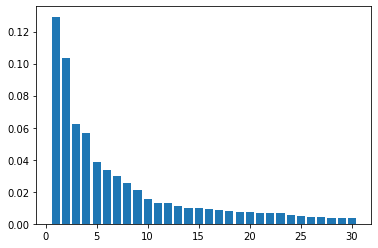

In [193]:
# plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.bar(range(1,31), pca.explained_variance_ratio_[1:31])

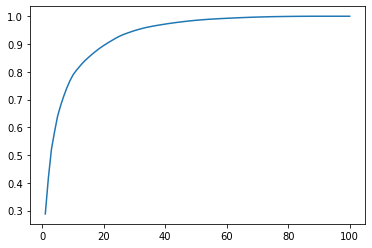

In [194]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

# Making the scree plot
plt.plot(range(1,len(var_cumu)+1), var_cumu)

In [195]:
pd.DataFrame(var_cumu).head(30)

,0
0,0.287862
1,0.417120
2,0.520710
3,0.583234
4,0.639945
5,0.678511
6,0.712052
7,0.741664
8,0.767236
9,0.788332


<font color='green'>
<b>PCA Inference:</b> <br>
- 94% of the variance is explained by the first 20 Principal Components <br>
- We can try running models with 20 components and check how they perform
</font>

## Create PCA datasets

In [196]:
num_pcs = 20

In [197]:
# Get the top 20 principal components 
pcs = IncrementalPCA(n_components=num_pcs)

In [198]:
# Utility method to create the new principal component datasets on the train & test data
def create_pca_data(train,test):
    train_pca = pd.DataFrame(pcs.fit_transform(train)).add_prefix('PC')
    # Index is lost after PCA as it works on Numpy arrays. 
    # Ref: https://github.com/scikit-learn/scikit-learn/issues/8238
    train_pca.index = train.index
    print(f'Train PCA data shape:{train_pca.shape}')
    display(train_pca.head(3))

    test_pca = pd.DataFrame(pcs.transform(test)).add_prefix('PC')
    test_pca.index = test.index
    print(f'Test PCA data shape:{test_pca.shape}')
    display(test_pca.head(3))
    
    
    
    return train_pca, test_pca
    

In [199]:
# Create PCA dataset for the original dataset
X_train_pca, X_test_pca = create_pca_data(X_train,X_test)

Train PCA data shape:(20589, 20)


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
39295,0.141542,0.083200,0.158264,-0.047496,-0.086339,-0.070294,-0.058376,0.066389,-0.152015,0.105858,-0.003986,-0.002200,0.023867,-0.028769,0.031778,0.026610,0.005530,-0.039386,0.024084,0.002228
69317,-0.066000,-0.140898,-0.037312,-0.048842,-0.131946,0.004394,-0.211718,0.069781,-0.252711,0.121616,0.007661,-0.017354,-0.014870,0.102520,0.020395,0.040508,0.079181,-0.034842,0.010351,-0.021400
56470,0.225787,-0.093175,-0.175502,-0.037222,-0.066990,-0.117431,-0.005534,0.016352,0.023907,0.044319,0.123207,0.046005,0.031073,-0.096420,0.034399,0.089218,-0.024668,-0.040885,-0.077292,-0.001240


Test PCA data shape:(8825, 20)


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
56927,0.048983,-0.340278,0.229373,-0.073287,-0.170927,-0.189457,0.207724,-0.070871,0.304588,0.098105,0.147325,0.014711,-0.005925,-0.198484,-0.109577,-0.103468,-0.010710,0.038275,-0.003866,-0.046447
74526,0.261238,-0.048142,-0.035168,1.170894,-0.281113,-0.002879,-0.320812,-0.015211,0.365793,0.088689,-0.137870,0.208785,-0.059484,0.049961,-0.069895,-0.312892,-0.392419,-0.672413,-0.270851,0.464487
71264,-0.104806,-0.514822,0.488051,-0.106919,-0.077655,-0.009713,-0.005202,0.038870,-0.052789,0.100465,0.042098,-0.017275,-0.034745,0.126221,0.015062,0.033531,0.066777,-0.026043,0.084837,-0.059603


In [200]:
# Create PCA dataset for the oversampled dataset
X_oversampled_train_pca, X_oversampled_test_pca = create_pca_data(X_oversampled_train,X_oversampled_test)

Train PCA data shape:(37927, 20)


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
8832,-0.945340,0.159304,0.028398,0.110242,0.098162,-0.529619,0.195733,0.279247,0.049838,0.128864,-0.175900,-0.161511,0.472838,-0.546893,-0.150858,-0.096876,0.037553,0.007753,-0.229956,0.047959
29160,-0.215855,0.344227,-0.097746,0.365958,-0.183397,0.215496,-0.172857,-0.241798,-0.015426,-0.090414,-0.158974,-0.225126,0.061503,0.254817,0.123228,0.083684,-0.020251,-0.027951,-0.003672,0.005381
33763,0.307683,-0.079166,-0.196592,-0.070124,-0.036009,-0.042120,0.116156,-0.056477,-0.096742,0.040112,0.089280,-0.056545,0.051012,0.052604,-0.034317,-0.136669,-0.024270,0.011024,-0.003513,0.006527


Test PCA data shape:(16255, 20)


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
28616,0.044292,-0.347067,0.542982,0.118212,0.015147,0.104400,-0.090806,0.086765,-0.039335,-0.064598,0.024534,0.013001,-0.010751,-0.007578,-0.006201,0.030093,-0.001483,-0.017380,0.004128,0.006604
40056,-0.113963,-0.276878,-0.272874,-0.092536,-0.007148,-0.106336,0.049024,-0.156683,-0.109870,0.026266,0.120964,-0.031854,0.476767,-0.148593,0.001270,0.085691,0.017298,-0.015530,0.336819,-0.055474
37037,-0.263960,0.399027,-0.103699,0.613554,-0.127952,-0.153997,-0.047305,0.001591,0.001013,0.025991,-0.074637,0.021746,0.005593,0.023737,-0.073633,0.020147,-0.017632,0.001212,-0.002322,0.009342


In [201]:
# Create PCA dataset for the SMOTE dataset
X_smote_train_pca, X_smote_test_pca = create_pca_data(X_smote_train,X_smote_test)

Train PCA data shape:(37927, 20)


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
8832,-0.957840,-0.085451,0.033640,0.111136,-0.456586,-0.331069,0.113012,0.295985,0.031546,0.135398,0.113574,-0.225574,0.243121,0.709475,-0.013828,-0.010295,-0.006224,0.004161,-0.199526,-0.021944
29160,-0.246405,-0.334705,-0.069392,0.364485,0.260851,0.102808,-0.136991,-0.254665,-0.015354,-0.087838,0.071714,-0.270161,0.142253,-0.242948,0.094722,-0.003260,-0.025379,-0.020446,-0.007298,0.020132
33763,0.274827,-0.004115,-0.190664,-0.056857,0.046912,-0.035216,0.111366,-0.006859,-0.082112,-0.038455,-0.054258,0.011156,0.025357,0.000294,-0.034762,0.090646,0.012170,-0.012440,0.008705,-0.029967


Test PCA data shape:(16255, 20)


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
28616,0.063221,0.393841,0.512686,0.104605,0.065837,0.098102,-0.081821,0.073306,-0.025561,-0.067399,-0.028835,0.017132,-0.013211,0.001035,0.017583,-0.023718,-0.012725,0.003972,0.001799,0.005262
40056,-0.180797,-0.306882,-0.181849,0.173113,0.226060,0.090700,-0.064844,-0.240235,-0.038588,-0.087026,0.057768,-0.119311,0.099167,-0.170605,0.048421,0.015520,-0.006740,-0.014944,-0.028418,0.122983
37037,0.235011,0.192328,0.352367,0.037382,0.060000,0.030303,-0.045999,0.061536,0.057095,-0.074724,0.050891,0.055040,0.012147,-0.015382,-0.041268,-0.030445,0.001583,0.034324,-0.010042,0.056996


## Check for multicollinearity - PCA

Verify that the features (Principal Components) created from PCA are not correlated to each other

In [202]:
corrmat = np.corrcoef(X_train_pca.transpose())
corrmat.shape

(20, 20)

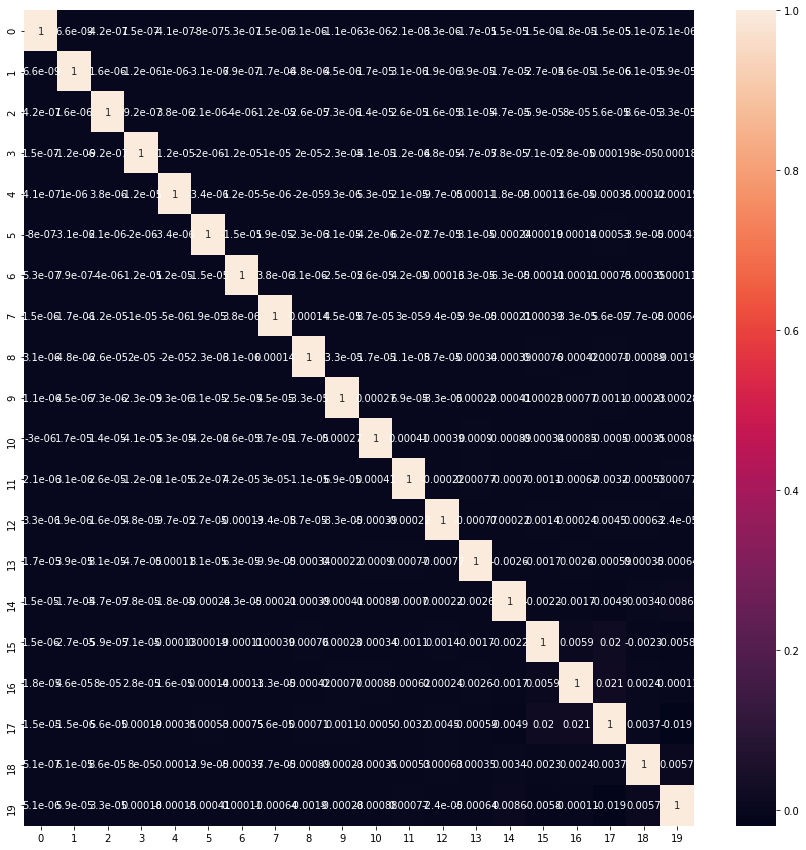

In [203]:
plt.figure(figsize=[15,15])
sns.heatmap(corrmat, annot=True)

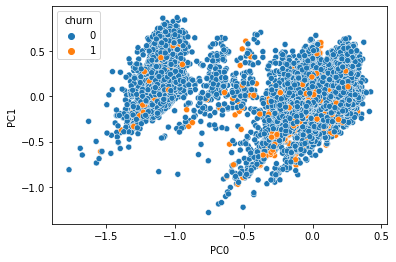

In [204]:
# Plotting the data of PC0 vs PC1
df_final = pd.concat([X_train_pca, y_train], axis=1)
sns.scatterplot(data=df_final, x="PC0", y="PC1",hue="churn")


## Model building - PCA

In [205]:
model_result_pca = pd.DataFrame()

### Default Model Building

In [206]:
# Default model run
run_all_models(X_train_pca, X_test_pca, y_train, y_test,'PCA',model_result_pca)
model_result_pca
#model_result_pca.T.sort_values(by=EVALUATION_METRIC,ascending=SORT_ASCENDING)


Running Model: Logistic Regression
Elapsed time: 0.0 min 0.144 sec

Running Model: Decision Tree Classifier
Elapsed time: 0.0 min 0.524 sec

Running Model: Random Forest Classifier
Elapsed time: 0.0 min 6.418 sec

Running Model: Naive Bayes Classifier
Elapsed time: 0.0 min 0.027 sec

Running Model: Gradient Boost Classifier
Elapsed time: 0.0 min 10.629 sec

Running Model: XGBoost Classifier
Elapsed time: 0.0 min 2.782 sec

Running Model: AdaBoost Classifier
Elapsed time: 0.0 min 2.254 sec

COMPLETED RUNNING ALL THE MODELS SUCCESSFULLY!!
Elapsed time: 0.0 min 22.779 sec


,PCA-LR,PCA-DCART,PCA-RF,PCA-NB,PCA-GB,PCA-XGB,PCA-ABC
Accuracy,92.748,88.861,92.816,89.020,93.008,92.997,92.499
Null Accuracy,91.977,91.977,91.977,91.977,91.977,91.977,91.977
AUROC,60.024,65.517,61.221,65.217,63.453,62.415,62.596
Sensitivity,21.045,37.712,23.588,36.864,28.249,25.989,26.977
Specificity,99.002,93.323,98.854,93.569,98.657,98.842,98.214
Precision,64.783,33.004,64.231,33.333,64.725,66.187,56.845
F1 Score,31.770,35.201,34.504,35.010,39.331,37.323,36.590
Negative Predictive Value,93.496,94.499,93.684,94.442,94.035,93.869,93.910
False Positive Rate,0.998,6.677,1.146,6.431,1.343,1.158,1.786
False Negative Rate,78.955,62.288,76.412,63.136,71.751,74.011,73.023


In [207]:
model_result_pca.T.sort_values(by=EVALUATION_METRIC,ascending=SORT_ASCENDING)

,Accuracy,Null Accuracy,AUROC,Sensitivity,Specificity,Precision,F1 Score,Negative Predictive Value,False Positive Rate,False Negative Rate,False Discovery Rate
PCA-GB,93.008,91.977,63.453,28.249,98.657,64.725,39.331,94.035,1.343,71.751,35.275
PCA-XGB,92.997,91.977,62.415,25.989,98.842,66.187,37.323,93.869,1.158,74.011,33.813
PCA-ABC,92.499,91.977,62.596,26.977,98.214,56.845,36.590,93.910,1.786,73.023,43.155
PCA-DCART,88.861,91.977,65.517,37.712,93.323,33.004,35.201,94.499,6.677,62.288,66.996
PCA-NB,89.020,91.977,65.217,36.864,93.569,33.333,35.010,94.442,6.431,63.136,66.667
PCA-RF,92.816,91.977,61.221,23.588,98.854,64.231,34.504,93.684,1.146,76.412,35.769
PCA-LR,92.748,91.977,60.024,21.045,99.002,64.783,31.770,93.496,0.998,78.955,35.217


### Model building with HPT

In [211]:
model_type_pca_hpt = 'PCA-HPT'

#### HPT for Random Forest

In [212]:
%%time
random_search_rf.fit(X_train_pca,y_train)
rf_best_est = random_search_rf.best_estimator_

Fitting 4 folds for each of 3 candidates, totalling 12 fits
CPU times: user 611 ms, sys: 128 ms, total: 739 ms
Wall time: 5.11 s


In [213]:
model_result_pca[f'{model_type_pca_hpt}-RF'] = model_fit_predict(rf_best_est,X_train_pca, X_test_pca, y_train, y_test)

#### HPT for XGBoost

In [214]:
%%time
random_search_xgb.fit(X_train_pca,y_train)
xgb_best_est = random_search_xgb.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
CPU times: user 16 s, sys: 162 ms, total: 16.1 s
Wall time: 1min 2s


In [215]:
model_result_pca[f'{model_type_pca_hpt}-XGB'] = model_fit_predict(xgb_best_est,X_train_pca, X_test_pca, y_train, y_test)

### Model on oversampled data

In [216]:
run_all_models(X_oversampled_train_pca, X_oversampled_test_pca, y_oversampled_train, y_oversampled_test,'PCA - Oversampled',model_result_pca)
model_result_pca.T


Running Model: Logistic Regression
Elapsed time: 0.0 min 0.218 sec

Running Model: Decision Tree Classifier
Elapsed time: 0.0 min 0.817 sec

Running Model: Random Forest Classifier
Elapsed time: 0.0 min 11.045 sec

Running Model: Naive Bayes Classifier
Elapsed time: 0.0 min 0.06 sec

Running Model: Gradient Boost Classifier
Elapsed time: 0.0 min 18.615 sec

Running Model: XGBoost Classifier
Elapsed time: 0.0 min 4.994 sec

Running Model: AdaBoost Classifier
Elapsed time: 0.0 min 4.068 sec

COMPLETED RUNNING ALL THE MODELS SUCCESSFULLY!!
Elapsed time: 0.0 min 39.819 sec


,PCA-LR,PCA-DCART,PCA-RF,PCA-NB,PCA-GB,PCA-XGB,PCA-ABC,PCA-HPT-RF,PCA-HPT-XGB,PCA - Oversampled-LR,PCA - Oversampled-DCART,PCA - Oversampled-RF,PCA - Oversampled-NB,PCA - Oversampled-GB,PCA - Oversampled-XGB,PCA - Oversampled-ABC
Accuracy,92.748,88.861,92.816,89.020,93.008,92.997,92.499,92.487,92.895,81.052,96.463,98.290,70.551,83.888,83.796,81.384
Null Accuracy,91.977,91.977,91.977,91.977,91.977,91.977,91.977,91.977,91.977,50.132,50.132,50.132,50.132,50.132,50.132,50.132
AUROC,60.024,65.517,61.221,65.217,63.453,62.415,62.596,53.887,65.518,81.051,96.472,98.294,70.587,83.885,83.792,81.380
Sensitivity,21.045,37.712,23.588,36.864,28.249,25.989,26.977,7.910,32.910,80.558,100.000,100.000,84.407,82.642,82.433,79.842
Specificity,99.002,93.323,98.854,93.569,98.657,98.842,98.214,99.864,98.127,81.544,92.944,96.589,56.768,85.127,85.152,82.918
Precision,64.783,33.004,64.231,33.333,64.725,66.187,56.845,83.582,60.519,81.280,93.376,96.684,66.011,84.680,84.668,82.299
F1 Score,31.770,35.201,34.504,35.010,39.331,37.323,36.590,14.452,42.635,80.917,96.575,98.314,74.084,83.649,83.535,81.052
Negative Predictive Value,93.496,94.499,93.684,94.442,94.035,93.869,93.910,92.555,94.372,80.830,100.000,100.000,78.540,83.138,82.973,80.527
False Positive Rate,0.998,6.677,1.146,6.431,1.343,1.158,1.786,0.136,1.873,18.456,7.056,3.411,43.232,14.873,14.848,17.082
False Negative Rate,78.955,62.288,76.412,63.136,71.751,74.011,73.023,92.090,67.090,19.442,0.000,0.000,15.593,17.358,17.567,20.158


### Model on SMOTE data

In [217]:
run_all_models(X_smote_train_pca, X_smote_test_pca, y_smote_train, y_smote_test,'PCA - SMOTE',model_result_pca)
model_result_pca.T


Running Model: Logistic Regression
Elapsed time: 0.0 min 0.235 sec

Running Model: Decision Tree Classifier
Elapsed time: 0.0 min 1.151 sec

Running Model: Random Forest Classifier
Elapsed time: 0.0 min 13.185 sec

Running Model: Naive Bayes Classifier
Elapsed time: 0.0 min 0.044 sec

Running Model: Gradient Boost Classifier
Elapsed time: 0.0 min 20.619 sec

Running Model: XGBoost Classifier
Elapsed time: 0.0 min 5.471 sec

Running Model: AdaBoost Classifier
Elapsed time: 0.0 min 4.308 sec

COMPLETED RUNNING ALL THE MODELS SUCCESSFULLY!!
Elapsed time: 0.0 min 45.015 sec


,PCA-LR,PCA-DCART,PCA-RF,PCA-NB,PCA-GB,PCA-XGB,PCA-ABC,PCA-HPT-RF,PCA-HPT-XGB,PCA - Oversampled-LR,...,PCA - Oversampled-GB,PCA - Oversampled-XGB,PCA - Oversampled-ABC,PCA - SMOTE-LR,PCA - SMOTE-DCART,PCA - SMOTE-RF,PCA - SMOTE-NB,PCA - SMOTE-GB,PCA - SMOTE-XGB,PCA - SMOTE-ABC
Accuracy,92.748,88.861,92.816,89.020,93.008,92.997,92.499,92.487,92.895,81.052,...,83.888,83.796,81.384,82.965,87.345,93.682,68.293,85.100,84.737,82.516
Null Accuracy,91.977,91.977,91.977,91.977,91.977,91.977,91.977,91.977,91.977,50.132,...,50.132,50.132,50.132,50.132,50.132,50.132,50.132,50.132,50.132,50.132
AUROC,60.024,65.517,61.221,65.217,63.453,62.415,62.596,53.887,65.518,81.051,...,83.885,83.792,81.380,82.966,87.349,93.687,68.345,85.097,84.734,82.515
Sensitivity,21.045,37.712,23.588,36.864,28.249,25.989,26.977,7.910,32.910,80.558,...,82.642,82.433,79.842,83.222,88.860,95.497,88.194,83.962,83.679,81.976
Specificity,99.002,93.323,98.854,93.569,98.657,98.842,98.214,99.864,98.127,81.544,...,85.127,85.152,82.918,82.710,85.839,91.876,48.497,86.231,85.790,83.053
Precision,64.783,33.004,64.231,33.333,64.725,66.187,56.845,83.582,60.519,81.280,...,84.680,84.668,82.299,82.722,86.191,92.122,63.009,85.848,85.417,82.793
F1 Score,31.770,35.201,34.504,35.010,39.331,37.323,36.590,14.452,42.635,80.917,...,83.649,83.535,81.052,82.972,87.505,93.779,73.504,84.895,84.539,82.383
Negative Predictive Value,93.496,94.499,93.684,94.442,94.035,93.869,93.910,92.555,94.372,80.830,...,83.138,82.973,80.527,83.210,88.567,95.352,80.505,84.388,84.087,82.246
False Positive Rate,0.998,6.677,1.146,6.431,1.343,1.158,1.786,0.136,1.873,18.456,...,14.873,14.848,17.082,17.290,14.161,8.124,51.503,13.769,14.210,16.947
False Negative Rate,78.955,62.288,76.412,63.136,71.751,74.011,73.023,92.090,67.090,19.442,...,17.358,17.567,20.158,16.778,11.140,4.503,11.806,16.038,16.321,18.024


### Model on (SMOTE + HPT)

In [218]:
model_type_pca_smotehpt = 'PCA-SMOTE+HPT'

#### SMOTE+HPT for Random Forest

In [219]:
%%time
# grid_search_rf.fit(X_smote_train_pca,y_smote_train)
# rf_smote_best_est = grid_search_rf.best_estimator_

random_search_rf.fit(X_smote_train_pca,y_smote_train)
rf_smote_best_est = random_search_rf.best_estimator_


Fitting 4 folds for each of 3 candidates, totalling 12 fits
CPU times: user 10.5 s, sys: 136 ms, total: 10.6 s
Wall time: 8.56 s


In [220]:
model_result_pca[f'{model_type_pca_smotehpt}-RF'] = model_fit_predict(rf_smote_best_est,X_smote_train_pca, X_smote_test_pca, y_smote_train, y_smote_test)

####  SMOTE+HPT for XGBoost

In [221]:
model_result_pca.T

,Accuracy,Null Accuracy,AUROC,Sensitivity,Specificity,Precision,F1 Score,Negative Predictive Value,False Positive Rate,False Negative Rate,False Discovery Rate
PCA-LR,92.748,91.977,60.024,21.045,99.002,64.783,31.770,93.496,0.998,78.955,35.217
PCA-DCART,88.861,91.977,65.517,37.712,93.323,33.004,35.201,94.499,6.677,62.288,66.996
PCA-RF,92.816,91.977,61.221,23.588,98.854,64.231,34.504,93.684,1.146,76.412,35.769
PCA-NB,89.020,91.977,65.217,36.864,93.569,33.333,35.010,94.442,6.431,63.136,66.667
PCA-GB,93.008,91.977,63.453,28.249,98.657,64.725,39.331,94.035,1.343,71.751,35.275
PCA-XGB,92.997,91.977,62.415,25.989,98.842,66.187,37.323,93.869,1.158,74.011,33.813
PCA-ABC,92.499,91.977,62.596,26.977,98.214,56.845,36.590,93.910,1.786,73.023,43.155
PCA-HPT-RF,92.487,91.977,53.887,7.910,99.864,83.582,14.452,92.555,0.136,92.090,16.418
PCA-HPT-XGB,92.895,91.977,65.518,32.910,98.127,60.519,42.635,94.372,1.873,67.090,39.481
PCA - Oversampled-LR,81.052,50.132,81.051,80.558,81.544,81.280,80.917,80.830,18.456,19.442,18.720


In [222]:
%%time
random_search_xgb.fit(X_smote_train_pca,y_smote_train)
xgb_smote_best_est = random_search_xgb.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
CPU times: user 44.2 s, sys: 138 ms, total: 44.3 s
Wall time: 2min 22s


In [223]:
model_result_pca[f'{model_type_pca_smotehpt}-XGB'] = model_fit_predict(xgb_smote_best_est,X_smote_train_pca, X_smote_test_pca, y_smote_train, y_smote_test)

## Summary from all models

In [224]:
model_result_pca.T.sort_values(by=EVALUATION_METRIC,ascending=SORT_ASCENDING)

,Accuracy,Null Accuracy,AUROC,Sensitivity,Specificity,Precision,F1 Score,Negative Predictive Value,False Positive Rate,False Negative Rate,False Discovery Rate
PCA - Oversampled-RF,98.290,50.132,98.294,100.000,96.589,96.684,98.314,100.000,3.411,0.000,3.316
PCA - Oversampled-DCART,96.463,50.132,96.472,100.000,92.944,93.376,96.575,100.000,7.056,0.000,6.624
PCA - SMOTE-RF,93.682,50.132,93.687,95.497,91.876,92.122,93.779,95.352,8.124,4.503,7.878
PCA-SMOTE+HPT-XGB,91.689,50.132,91.693,93.425,89.962,90.251,91.811,93.222,10.038,6.575,9.749
PCA - SMOTE-DCART,87.345,50.132,87.349,88.860,85.839,86.191,87.505,88.567,14.161,11.140,13.809
PCA-SMOTE+HPT-RF,85.549,50.132,85.545,83.876,87.213,86.711,85.270,84.466,12.787,16.124,13.289
PCA - SMOTE-GB,85.100,50.132,85.097,83.962,86.231,85.848,84.895,84.388,13.769,16.038,14.152
PCA - SMOTE-XGB,84.737,50.132,84.734,83.679,85.790,85.417,84.539,84.087,14.210,16.321,14.583
PCA - Oversampled-GB,83.888,50.132,83.885,82.642,85.127,84.680,83.649,83.138,14.873,17.358,15.320
PCA - Oversampled-XGB,83.796,50.132,83.792,82.433,85.152,84.668,83.535,82.973,14.848,17.567,15.332


<font color = 'green'>
    <b>Insights from the summary table - PCA</b><br>
- Models with oversampled data & smote data perform better than the models without any class imbalance treatement <br> 
- Models run on oversampled data perform better than models run on SMOTE data<br>
- Random Forest performs well with this data<br>
- While running with the original dataset (without addressing the class imbalance), the hyperparameter tuned model with XGB outperforms the other models.<br>
</font>

# Model building 2 - without PCA

## Build  Models

In [225]:
model_result_featimp = pd.DataFrame()

### Default model building

In [226]:
# Default model run - Feature Importance (FI)
run_all_models(X_train, X_test, y_train, y_test,'FI', model_result_featimp)

model_result_featimp.T.sort_values(by=EVALUATION_METRIC,ascending=SORT_ASCENDING)


Running Model: Logistic Regression
Elapsed time: 0.0 min 0.558 sec

Running Model: Decision Tree Classifier
Elapsed time: 0.0 min 1.336 sec

Running Model: Random Forest Classifier
Elapsed time: 0.0 min 7.483 sec

Running Model: Naive Bayes Classifier
Elapsed time: 0.0 min 0.071 sec

Running Model: Gradient Boost Classifier
Elapsed time: 0.0 min 21.855 sec

Running Model: XGBoost Classifier
Elapsed time: 0.0 min 9.725 sec

Running Model: AdaBoost Classifier
Elapsed time: 0.0 min 4.548 sec

COMPLETED RUNNING ALL THE MODELS SUCCESSFULLY!!
Elapsed time: 0.0 min 45.577 sec


,Accuracy,Null Accuracy,AUROC,Sensitivity,Specificity,Precision,F1 Score,Negative Predictive Value,False Positive Rate,False Negative Rate,False Discovery Rate
FI-GB,94.754,91.977,76.069,53.814,98.325,73.694,62.204,96.064,1.675,46.186,26.306
FI-XGB,94.652,91.977,75.369,52.401,98.337,73.320,61.120,95.949,1.663,47.599,26.680
FI-RF,94.629,91.977,72.714,46.610,98.817,77.465,58.201,95.499,1.183,53.390,22.535
FI-ABC,94.119,91.977,73.532,49.011,98.053,68.713,57.214,95.661,1.947,50.989,31.287
FI-DCART,92.011,91.977,73.740,51.977,95.503,50.205,51.076,95.798,4.497,48.023,49.795
FI-LR,92.895,91.977,60.877,22.740,99.014,66.805,33.930,93.628,0.986,77.260,33.195
FI-NB,47.037,91.977,66.181,88.983,43.378,12.055,21.234,97.833,56.622,11.017,87.945


### Model with HPT

In [227]:
model_type_FI_hpt = 'FI-HPT'

#### HPT for Random Forest

In [228]:
%%time
#grid_search_rf.fit(X_train,y_train)
#rf_fi_best_est = grid_search_rf.best_estimator_
random_search_rf.fit(X_train,y_train)
rf_fi_best_est = random_search_rf.best_estimator_

Fitting 4 folds for each of 3 candidates, totalling 12 fits
CPU times: user 368 ms, sys: 115 ms, total: 483 ms
Wall time: 3.87 s


In [229]:
model_result_featimp[f'{model_type_FI_hpt}-RF'] = model_fit_predict(rf_fi_best_est,X_train, X_test, y_train, y_test)

#### HPT for XGBoost

In [230]:
%%time
random_search_xgb.fit(X_train,y_train)
xgb_fi_best_est = random_search_xgb.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
CPU times: user 49.3 s, sys: 176 ms, total: 49.5 s
Wall time: 3min 2s


In [231]:
model_result_featimp[f'{model_type_FI_hpt}-XGB'] = model_fit_predict(xgb_fi_best_est,X_train, X_test, y_train, y_test)

### Model with Oversampled Data

In [232]:
run_all_models(X_oversampled_train, X_oversampled_test, y_oversampled_train, y_oversampled_test,'FI - Oversampled', model_result_featimp)

model_result_featimp.T.sort_values(by=EVALUATION_METRIC,ascending=SORT_ASCENDING)


Running Model: Logistic Regression
Elapsed time: 0.0 min 0.907 sec

Running Model: Decision Tree Classifier
Elapsed time: 0.0 min 2.174 sec

Running Model: Random Forest Classifier
Elapsed time: 0.0 min 12.719 sec

Running Model: Naive Bayes Classifier
Elapsed time: 0.0 min 0.119 sec

Running Model: Gradient Boost Classifier
Elapsed time: 0.0 min 33.027 sec

Running Model: XGBoost Classifier
Elapsed time: 0.0 min 17.376 sec

Running Model: AdaBoost Classifier
Elapsed time: 0.0 min 7.138 sec

COMPLETED RUNNING ALL THE MODELS SUCCESSFULLY!!
Elapsed time: 1.0 min 72.46 sec


,Accuracy,Null Accuracy,AUROC,Sensitivity,Specificity,Precision,F1 Score,Negative Predictive Value,False Positive Rate,False Negative Rate,False Discovery Rate
FI - Oversampled-RF,98.831,50.132,98.834,100.000,97.668,97.710,98.842,100.000,2.332,0.000,2.290
FI - Oversampled-DCART,97.336,50.132,97.343,100.000,94.686,94.929,97.399,100.000,5.314,0.000,5.071
FI - Oversampled-GB,90.840,50.132,90.841,91.426,90.256,90.323,90.871,91.366,9.744,8.574,9.677
FI - Oversampled-XGB,90.637,50.132,90.638,91.179,90.097,90.156,90.665,91.126,9.903,8.821,9.844
FI - Oversampled-ABC,86.706,50.132,86.701,85.060,88.342,87.890,86.452,85.600,11.658,14.940,12.110
FI - Oversampled-LR,83.390,50.132,83.392,84.123,82.660,82.835,83.474,83.959,17.340,15.877,17.165
FI - Oversampled-NB,65.986,50.132,66.053,91.340,40.766,60.535,72.813,82.555,59.234,8.660,39.465
FI-HPT-XGB,94.833,91.977,77.208,56.215,98.201,73.162,63.578,96.256,1.799,43.785,26.838
FI-GB,94.754,91.977,76.069,53.814,98.325,73.694,62.204,96.064,1.675,46.186,26.306
FI-XGB,94.652,91.977,75.369,52.401,98.337,73.320,61.120,95.949,1.663,47.599,26.680


### Model with SMOTE Data

In [233]:
run_all_models(X_smote_train, X_smote_test, y_smote_train, y_smote_test,'FI - SMOTE', model_result_featimp)

model_result_featimp.T.sort_values(by=EVALUATION_METRIC,ascending=SORT_ASCENDING)


Running Model: Logistic Regression
Elapsed time: 0.0 min 1.006 sec

Running Model: Decision Tree Classifier
Elapsed time: 0.0 min 3.546 sec

Running Model: Random Forest Classifier
Elapsed time: 0.0 min 18.355 sec

Running Model: Naive Bayes Classifier
Elapsed time: 0.0 min 0.12 sec

Running Model: Gradient Boost Classifier
Elapsed time: 0.0 min 46.846 sec

Running Model: XGBoost Classifier
Elapsed time: 0.0 min 19.122 sec

Running Model: AdaBoost Classifier
Elapsed time: 0.0 min 9.794 sec

COMPLETED RUNNING ALL THE MODELS SUCCESSFULLY!!
Elapsed time: 1.0 min 97.789 sec


,Accuracy,Null Accuracy,AUROC,Sensitivity,Specificity,Precision,F1 Score,Negative Predictive Value,False Positive Rate,False Negative Rate,False Discovery Rate
FI - Oversampled-RF,98.831,50.132,98.834,100.000,97.668,97.710,98.842,100.000,2.332,0.000,2.290
FI - Oversampled-DCART,97.336,50.132,97.343,100.000,94.686,94.929,97.399,100.000,5.314,0.000,5.071
FI - SMOTE-RF,96.955,50.132,96.957,97.779,96.134,96.178,96.972,97.754,3.866,2.221,3.822
FI - SMOTE-XGB,93.867,50.132,93.868,94.572,93.165,93.226,93.894,94.522,6.835,5.428,6.774
FI - SMOTE-GB,93.830,50.132,93.831,94.350,93.312,93.348,93.846,94.319,6.688,5.650,6.652
FI - SMOTE-DCART,92.125,50.132,92.130,93.869,90.391,90.670,92.241,93.679,9.609,6.131,9.330
FI - SMOTE-ABC,91.480,50.132,91.480,91.488,91.471,91.431,91.460,91.528,8.529,8.512,8.569
FI - Oversampled-GB,90.840,50.132,90.841,91.426,90.256,90.323,90.871,91.366,9.744,8.574,9.677
FI - Oversampled-XGB,90.637,50.132,90.638,91.179,90.097,90.156,90.665,91.126,9.903,8.821,9.844
FI - SMOTE-LR,86.441,50.132,86.444,87.713,85.176,85.477,86.581,87.451,14.824,12.287,14.523


### Model with SMOTE+HPT

In [234]:
model_type_FI_smotehpt = 'FI-SMOTE+HPT'

#### HPT for Random Forest

In [235]:
%%time
# grid_search_rf.fit(X_smote_train_pca,y_smote_train)
# rf_fi_smote_best_est = grid_search_rf.best_estimator_

random_search_rf.fit(X_smote_train,y_smote_train)
rf_fi_smote_best_est = random_search_rf.best_estimator_


Fitting 4 folds for each of 3 candidates, totalling 12 fits
CPU times: user 5.8 s, sys: 177 ms, total: 5.98 s
Wall time: 5.95 s


In [236]:
model_result_featimp[f'{model_type_FI_smotehpt}-RF'] = model_fit_predict(rf_fi_smote_best_est,X_smote_train, X_smote_test, y_smote_train, y_smote_test)

#### HPT for XGBoost

In [237]:
%%time
random_search_xgb.fit(X_smote_train,y_smote_train)
xgb_fi_smote_best_est = random_search_xgb.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
CPU times: user 2min 8s, sys: 312 ms, total: 2min 9s
Wall time: 28min 38s


In [239]:
model_result_featimp[f'{model_type_FI_smotehpt}-XGB'] = model_fit_predict(xgb_fi_smote_best_est,X_smote_train, X_smote_test, y_smote_train, y_smote_test)

### Summary from all the Models

In [240]:

model_result_featimp.T.sort_values(by=EVALUATION_METRIC,ascending=SORT_ASCENDING)

,Accuracy,Null Accuracy,AUROC,Sensitivity,Specificity,Precision,F1 Score,Negative Predictive Value,False Positive Rate,False Negative Rate,False Discovery Rate
FI - Oversampled-RF,98.831,50.132,98.834,100.000,97.668,97.710,98.842,100.000,2.332,0.000,2.290
FI - Oversampled-DCART,97.336,50.132,97.343,100.000,94.686,94.929,97.399,100.000,5.314,0.000,5.071
FI-SMOTE+HPT-XGB,97.084,50.132,97.085,97.582,96.589,96.605,97.091,97.570,3.411,2.418,3.395
FI - SMOTE-RF,96.955,50.132,96.957,97.779,96.134,96.178,96.972,97.754,3.866,2.221,3.822
FI - SMOTE-XGB,93.867,50.132,93.868,94.572,93.165,93.226,93.894,94.522,6.835,5.428,6.774
FI - SMOTE-GB,93.830,50.132,93.831,94.350,93.312,93.348,93.846,94.319,6.688,5.650,6.652
FI - SMOTE-DCART,92.125,50.132,92.130,93.869,90.391,90.670,92.241,93.679,9.609,6.131,9.330
FI - SMOTE-ABC,91.480,50.132,91.480,91.488,91.471,91.431,91.460,91.528,8.529,8.512,8.569
FI - Oversampled-GB,90.840,50.132,90.841,91.426,90.256,90.323,90.871,91.366,9.744,8.574,9.677
FI - Oversampled-XGB,90.637,50.132,90.638,91.179,90.097,90.156,90.665,91.126,9.903,8.821,9.844


<font color = 'green'>
    <b>Insights from the summary table</b><br>
- Comparing the model performances in the above summary table, it is clear that the model performs better when the class imbalance issue is addressed.<br>
- Models run on oversampled data perform better than models run on SMOTE data<br>
- Random Forest performs well with this data<br>
- While running with the original dataset (without addressing the class imbalance), the hyperparameter tuned model with XGB outperforms the other models.<br>
</font>

### Best Model for Feature Importance

## Feature Importance with Random Forest & XGB models

In [241]:
print(f'Important features from Random Forest HPT model')

imp_rf_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": rf_fi_best_est.feature_importances_
})
imp_rf_df.sort_values(by="Imp", ascending=False)

Important features from Random Forest HPT model


,Varname,Imp
38,std_ic_mou_8,0.074018
50,last_day_rch_amt_8,0.070383
97,max_rech_amt_gaphase_avg,0.069062
79,total_mou_gaphase_avg,0.061257
90,total_rech_amt_avg,0.050278
11,std_og_t2m_mou_8,0.046515
85,loc_og_gaphase_avg,0.046068
2,onnet_mou_8,0.042209
91,total_rech_amt_gaphase_avg,0.038722
84,loc_og_avg,0.036914


In [242]:
print(f'Important features from XGB HPT model')

imp_xgb_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": xgb_fi_best_est.feature_importances_
})
imp_xgb_df.sort_values(by="Imp", ascending=False)

Important features from XGB HPT model


,Varname,Imp
50,last_day_rch_amt_8,0.069691
53,night_pck_user_8,0.065957
68,fb_user_8,0.053252
38,std_ic_mou_8,0.043453
5,offnet_mou_8,0.038495
77,arpu_gaphase_avg,0.029112
32,std_ic_t2m_mou_8,0.022962
73,sep_vbc_3g,0.020930
41,spl_ic_mou_8,0.020875
89,roam_mou_gaphase_avg,0.020825


In [243]:
print(f'Important features from RF - oversampled model')
model_rf_oversampled = RandomForestClassifier(random_state=42).fit(X_oversampled_train, y_oversampled_train)

imp_rf_oversampled_df = pd.DataFrame({
    "Varname": X_oversampled_train.columns,
    "Imp": model_rf_oversampled.feature_importances_
})
imp_rf_oversampled_df.sort_values(by="Imp", ascending=False)

Important features from RF - oversampled model


,Varname,Imp
50,last_day_rch_amt_8,0.061172
91,total_rech_amt_gaphase_avg,0.055416
77,arpu_gaphase_avg,0.048702
68,fb_user_8,0.045497
79,total_mou_gaphase_avg,0.039936
38,std_ic_mou_8,0.039926
87,loc_ic_gaphase_avg,0.036744
89,roam_mou_gaphase_avg,0.036398
74,last_rech_num_days,0.036153
32,std_ic_t2m_mou_8,0.023613


In [ ]:
## Correlation matrix with the target for the important features

In [259]:
imp_features = ['total_rech_amt_gaphase_avg','arpu_gaphase_avg','total_mou_gaphase_avg','fb_user_8','loc_ic_avg','aon']

In [260]:
df = cust[imp_features + ['churn']]
corr = df.corr() 

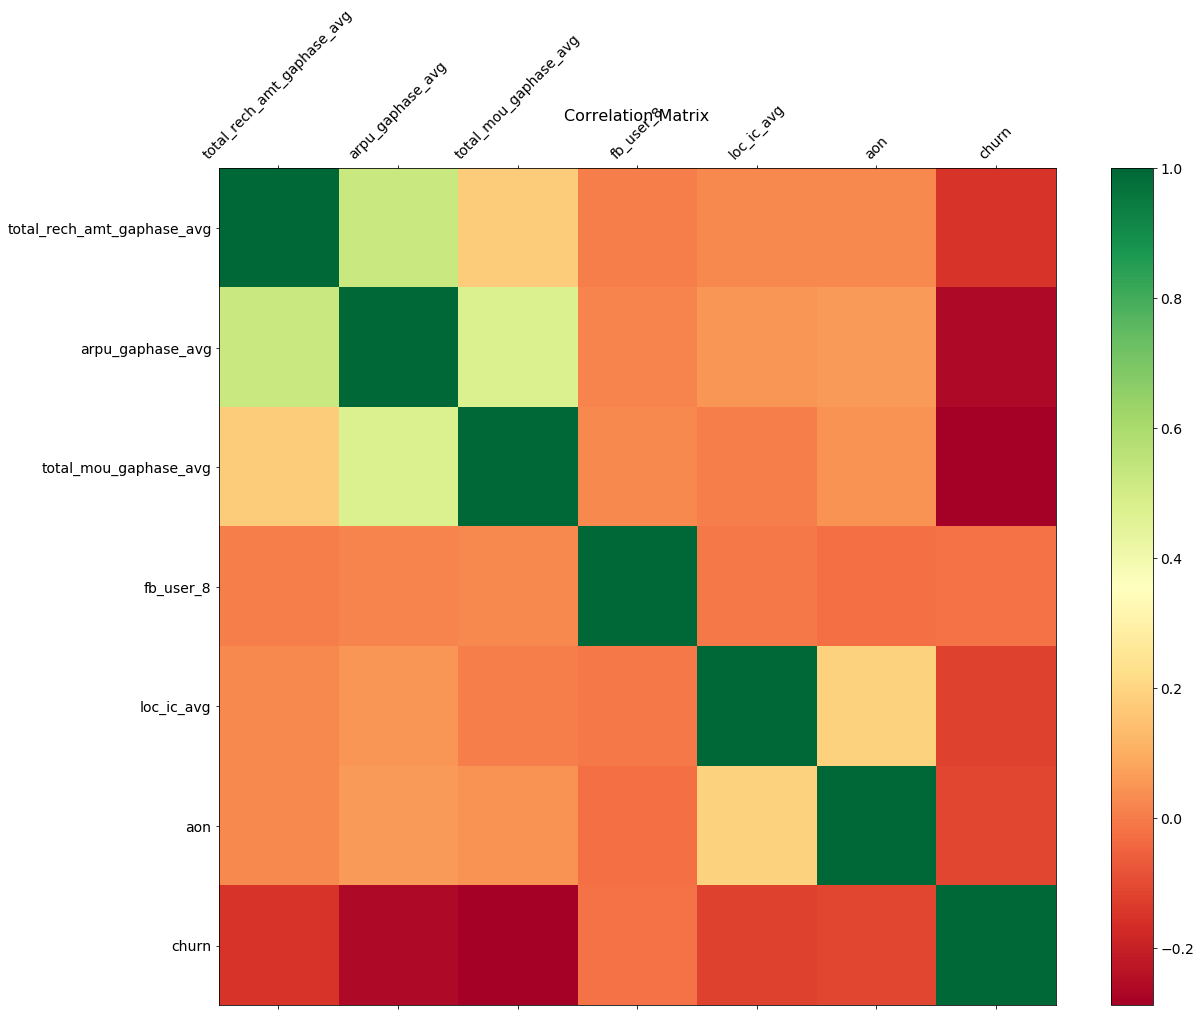

In [261]:
f = plt.figure(figsize=(20, 15))

ax = plt.matshow(corr, fignum=f.number,cmap='RdYlGn')
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#ax.set_ylim([0,2])
plt.title('Correlation Matrix', fontsize=16);

In [262]:

corr.style.background_gradient(cmap='coolwarm').set_precision(1)

,total_rech_amt_gaphase_avg,arpu_gaphase_avg,total_mou_gaphase_avg,fb_user_8,loc_ic_avg,aon,churn
total_rech_amt_gaphase_avg,1,0.5,0.2,0.006,0.02,0.03,-0.1
arpu_gaphase_avg,0.5,1,0.5,0.02,0.05,0.06,-0.3
total_mou_gaphase_avg,0.2,0.5,1,0.03,0.005,0.05,-0.3
fb_user_8,0.006,0.02,0.03,1,-0.004,-0.03,-0.02
loc_ic_avg,0.02,0.05,0.005,-0.004,1,0.2,-0.1
aon,0.03,0.06,0.05,-0.03,0.2,1,-0.1
churn,-0.1,-0.3,-0.3,-0.02,-0.1,-0.1,1


# Insights

## Best Model - with PCA

Finally, choose a model based on some evaluation metric.

<font color='green'>
<b>INSIGHTS:</b> <br>
- Models were created with 3 different types of data: <br>
-- Input Data<br>
-- Oversampled Data<br>
-- SMOTE Data<br>
- Based on the F1-Score and AUROC, we can notice that the models created with the oversampled data before the best.<br>
- <br>
- The models with oversampled data perform better than the <br>
</font>

## Important features

After identifying important predictors, display them visually - you can use plots, summary tables etc. - whatever you think best conveys the importance of features.

## Conclusion - recommendation to manage customer churn

Finally, recommend strategies to manage customer churn based on your observations.